In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.447), (0.247, 0.243, 0.262))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)


In [4]:
DenseNet = models.densenet121(pretrained = True)
DenseNet.classifier = nn.Linear(1024, 10)
DenseNet.to(device)
print(DenseNet)

/home/rushik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rushik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/rushik/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_390646/1444421727.py", line 3, in <module>
    DenseNet.to(device)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1174, in to
    return self._apply(convert)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 780, in _apply
    module._apply(fn)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 780, in _apply
    module._apply(fn)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 805, in _apply
    param_applied = fn(param)
  File "/home/rushik/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1160, in convert
    return t.to(
RuntimeError: CUDA error: out of memory
CUDA kernel errors m

In [6]:
# optimizer
optimizer = optim.SGD(DenseNet.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [7]:
#transformations for metamorphic testing
transformations = [
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.2),  # Slight brightness change
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Small translation
]

In [8]:
# Validation Function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == target).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)
    
    # Calculate metrics
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    return val_loss, val_accuracy, precision, recall, f1

In [9]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for  data, target in tqdm(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [10]:
reject_diffs = []

# If batch_size > 1, we get multiple images each iteration.
for i, (image, label) in enumerate(tqdm(testloader)):
   
    image = image.to(device)


    with torch.no_grad():
        original_output = DenseNet(image)
        original_prob = F.softmax(original_output, dim=1)
        original_confidence, original_pred = torch.max(original_prob, dim=1)  # shape [batch_size]

    
    for tf in transformations:
        transformed_image = tf(image.cpu()).to(device)
        
        with torch.no_grad():
            transformed_output = DenseNet(transformed_image)
            transformed_prob = F.softmax(transformed_output, dim=1)
            transformed_confidence, transformed_pred = torch.max(transformed_prob, dim=1)
        
        # Compute absolute difference in confidence for the entire batch
        # shape [batch_size]
        diff_tensor = torch.abs(original_confidence - transformed_confidence)

        
        diff_mean = diff_tensor.mean().item()
        reject_diffs.append(diff_mean)

        
        print(f"Batch {i} | "
              f"Reject Differential (mean over batch): {diff_mean:.4f}")

  0%|▎                                                                                                                                                                    | 1/625 [00:00<06:39,  1.56it/s]

Batch 0 | Reject Differential (mean over batch): 0.0401
Batch 0 | Reject Differential (mean over batch): 0.0358
Batch 0 | Reject Differential (mean over batch): 0.0401


  0%|▌                                                                                                                                                                    | 2/625 [00:00<03:58,  2.61it/s]

Batch 1 | Reject Differential (mean over batch): 0.0356
Batch 1 | Reject Differential (mean over batch): 0.0426
Batch 1 | Reject Differential (mean over batch): 0.0261


  0%|▊                                                                                                                                                                    | 3/625 [00:01<03:06,  3.34it/s]

Batch 2 | Reject Differential (mean over batch): 0.0292
Batch 2 | Reject Differential (mean over batch): 0.0298
Batch 2 | Reject Differential (mean over batch): 0.0198
Batch 3 | Reject Differential (mean over batch): 0.0233


  1%|█                                                                                                                                                                    | 4/625 [00:01<02:41,  3.84it/s]

Batch 3 | Reject Differential (mean over batch): 0.0359
Batch 3 | Reject Differential (mean over batch): 0.0285
Batch 4 | Reject Differential (mean over batch): 0.0340


  1%|█▎                                                                                                                                                                   | 5/625 [00:01<02:29,  4.15it/s]

Batch 4 | Reject Differential (mean over batch): 0.0351
Batch 4 | Reject Differential (mean over batch): 0.0275
Batch 5 | Reject Differential (mean over batch): 0.0315


  1%|█▌                                                                                                                                                                   | 6/625 [00:01<02:21,  4.38it/s]

Batch 5 | Reject Differential (mean over batch): 0.0381
Batch 5 | Reject Differential (mean over batch): 0.0302
Batch 6 | Reject Differential (mean over batch): 0.0296


  1%|█▊                                                                                                                                                                   | 7/625 [00:01<02:16,  4.54it/s]

Batch 6 | Reject Differential (mean over batch): 0.0499
Batch 6 | Reject Differential (mean over batch): 0.0225
Batch 7 | Reject Differential (mean over batch): 0.0258


  1%|██                                                                                                                                                                   | 8/625 [00:02<02:11,  4.69it/s]

Batch 7 | Reject Differential (mean over batch): 0.0435
Batch 7 | Reject Differential (mean over batch): 0.0190
Batch 8 | Reject Differential (mean over batch): 0.0268
Batch 8 | Reject Differential (mean over batch): 0.0430


  2%|██▌                                                                                                                                                                 | 10/625 [00:02<02:02,  5.04it/s]

Batch 8 | Reject Differential (mean over batch): 0.0339
Batch 9 | Reject Differential (mean over batch): 0.0290
Batch 9 | Reject Differential (mean over batch): 0.0219
Batch 9 | Reject Differential (mean over batch): 0.0379


  2%|██▉                                                                                                                                                                 | 11/625 [00:02<01:59,  5.14it/s]

Batch 10 | Reject Differential (mean over batch): 0.0265
Batch 10 | Reject Differential (mean over batch): 0.0405
Batch 10 | Reject Differential (mean over batch): 0.0317
Batch 11 | Reject Differential (mean over batch): 0.0259


  2%|███▏                                                                                                                                                                | 12/625 [00:02<01:57,  5.21it/s]

Batch 11 | Reject Differential (mean over batch): 0.0237
Batch 11 | Reject Differential (mean over batch): 0.0149
Batch 12 | Reject Differential (mean over batch): 0.0246
Batch 12 | Reject Differential (mean over batch): 0.0347


  2%|███▋                                                                                                                                                                | 14/625 [00:03<01:54,  5.33it/s]

Batch 12 | Reject Differential (mean over batch): 0.0230
Batch 13 | Reject Differential (mean over batch): 0.0325
Batch 13 | Reject Differential (mean over batch): 0.0337
Batch 13 | Reject Differential (mean over batch): 0.0257


  2%|███▉                                                                                                                                                                | 15/625 [00:03<01:54,  5.34it/s]

Batch 14 | Reject Differential (mean over batch): 0.0189
Batch 14 | Reject Differential (mean over batch): 0.0315
Batch 14 | Reject Differential (mean over batch): 0.0243
Batch 15 | Reject Differential (mean over batch): 0.0333


  3%|████▏                                                                                                                                                               | 16/625 [00:03<01:54,  5.34it/s]

Batch 15 | Reject Differential (mean over batch): 0.0310
Batch 15 | Reject Differential (mean over batch): 0.0236
Batch 16 | Reject Differential (mean over batch): 0.0389
Batch 16 | Reject Differential (mean over batch): 0.0363


  3%|████▋                                                                                                                                                               | 18/625 [00:03<01:55,  5.25it/s]

Batch 16 | Reject Differential (mean over batch): 0.0167
Batch 17 | Reject Differential (mean over batch): 0.0262
Batch 17 | Reject Differential (mean over batch): 0.0389
Batch 17 | Reject Differential (mean over batch): 0.0337


  3%|████▉                                                                                                                                                               | 19/625 [00:04<01:54,  5.29it/s]

Batch 18 | Reject Differential (mean over batch): 0.0299
Batch 18 | Reject Differential (mean over batch): 0.0314
Batch 18 | Reject Differential (mean over batch): 0.0401
Batch 19 | Reject Differential (mean over batch): 0.0359


  3%|█████▏                                                                                                                                                              | 20/625 [00:04<01:53,  5.33it/s]

Batch 19 | Reject Differential (mean over batch): 0.0370
Batch 19 | Reject Differential (mean over batch): 0.0346
Batch 20 | Reject Differential (mean over batch): 0.0287
Batch 20 | Reject Differential (mean over batch): 0.0380


  4%|█████▊                                                                                                                                                              | 22/625 [00:04<01:52,  5.36it/s]

Batch 20 | Reject Differential (mean over batch): 0.0250
Batch 21 | Reject Differential (mean over batch): 0.0293
Batch 21 | Reject Differential (mean over batch): 0.0393
Batch 21 | Reject Differential (mean over batch): 0.0309


  4%|██████                                                                                                                                                              | 23/625 [00:04<01:52,  5.35it/s]

Batch 22 | Reject Differential (mean over batch): 0.0272
Batch 22 | Reject Differential (mean over batch): 0.0236
Batch 22 | Reject Differential (mean over batch): 0.0251
Batch 23 | Reject Differential (mean over batch): 0.0260


  4%|██████▎                                                                                                                                                             | 24/625 [00:05<01:54,  5.25it/s]

Batch 23 | Reject Differential (mean over batch): 0.0374
Batch 23 | Reject Differential (mean over batch): 0.0272
Batch 24 | Reject Differential (mean over batch): 0.0181
Batch 24 | Reject Differential (mean over batch): 0.0352


  4%|██████▊                                                                                                                                                             | 26/625 [00:05<01:53,  5.26it/s]

Batch 24 | Reject Differential (mean over batch): 0.0303
Batch 25 | Reject Differential (mean over batch): 0.0343
Batch 25 | Reject Differential (mean over batch): 0.0312
Batch 25 | Reject Differential (mean over batch): 0.0305


  4%|███████                                                                                                                                                             | 27/625 [00:05<01:52,  5.29it/s]

Batch 26 | Reject Differential (mean over batch): 0.0319
Batch 26 | Reject Differential (mean over batch): 0.0410
Batch 26 | Reject Differential (mean over batch): 0.0240
Batch 27 | Reject Differential (mean over batch): 0.0295


  4%|███████▎                                                                                                                                                            | 28/625 [00:05<01:52,  5.30it/s]

Batch 27 | Reject Differential (mean over batch): 0.0337
Batch 27 | Reject Differential (mean over batch): 0.0220
Batch 28 | Reject Differential (mean over batch): 0.0372
Batch 28 | Reject Differential (mean over batch): 0.0618


  5%|███████▊                                                                                                                                                            | 30/625 [00:06<01:50,  5.36it/s]

Batch 28 | Reject Differential (mean over batch): 0.0353
Batch 29 | Reject Differential (mean over batch): 0.0202
Batch 29 | Reject Differential (mean over batch): 0.0419
Batch 29 | Reject Differential (mean over batch): 0.0369


  5%|████████▏                                                                                                                                                           | 31/625 [00:06<01:50,  5.36it/s]

Batch 30 | Reject Differential (mean over batch): 0.0350
Batch 30 | Reject Differential (mean over batch): 0.0427
Batch 30 | Reject Differential (mean over batch): 0.0239
Batch 31 | Reject Differential (mean over batch): 0.0309


  5%|████████▍                                                                                                                                                           | 32/625 [00:06<01:50,  5.34it/s]

Batch 31 | Reject Differential (mean over batch): 0.0321
Batch 31 | Reject Differential (mean over batch): 0.0286
Batch 32 | Reject Differential (mean over batch): 0.0329
Batch 32 | Reject Differential (mean over batch): 0.0293


  5%|████████▉                                                                                                                                                           | 34/625 [00:06<01:52,  5.26it/s]

Batch 32 | Reject Differential (mean over batch): 0.0242
Batch 33 | Reject Differential (mean over batch): 0.0266
Batch 33 | Reject Differential (mean over batch): 0.0231
Batch 33 | Reject Differential (mean over batch): 0.0186


  6%|█████████▏                                                                                                                                                          | 35/625 [00:07<01:51,  5.29it/s]

Batch 34 | Reject Differential (mean over batch): 0.0330
Batch 34 | Reject Differential (mean over batch): 0.0301
Batch 34 | Reject Differential (mean over batch): 0.0237
Batch 35 | Reject Differential (mean over batch): 0.0300


  6%|█████████▍                                                                                                                                                          | 36/625 [00:07<01:50,  5.33it/s]

Batch 35 | Reject Differential (mean over batch): 0.0325
Batch 35 | Reject Differential (mean over batch): 0.0214
Batch 36 | Reject Differential (mean over batch): 0.0359
Batch 36 | Reject Differential (mean over batch): 0.0284


  6%|█████████▉                                                                                                                                                          | 38/625 [00:07<01:49,  5.37it/s]

Batch 36 | Reject Differential (mean over batch): 0.0242
Batch 37 | Reject Differential (mean over batch): 0.0254
Batch 37 | Reject Differential (mean over batch): 0.0320
Batch 37 | Reject Differential (mean over batch): 0.0227


  6%|██████████▏                                                                                                                                                         | 39/625 [00:07<01:49,  5.37it/s]

Batch 38 | Reject Differential (mean over batch): 0.0386
Batch 38 | Reject Differential (mean over batch): 0.0387
Batch 38 | Reject Differential (mean over batch): 0.0374
Batch 39 | Reject Differential (mean over batch): 0.0361


  6%|██████████▍                                                                                                                                                         | 40/625 [00:08<01:48,  5.38it/s]

Batch 39 | Reject Differential (mean over batch): 0.0410
Batch 39 | Reject Differential (mean over batch): 0.0256
Batch 40 | Reject Differential (mean over batch): 0.0307
Batch 40 | Reject Differential (mean over batch): 0.0378


  7%|███████████                                                                                                                                                         | 42/625 [00:08<01:48,  5.39it/s]

Batch 40 | Reject Differential (mean over batch): 0.0268
Batch 41 | Reject Differential (mean over batch): 0.0288
Batch 41 | Reject Differential (mean over batch): 0.0321
Batch 41 | Reject Differential (mean over batch): 0.0289


  7%|███████████▎                                                                                                                                                        | 43/625 [00:08<01:48,  5.38it/s]

Batch 42 | Reject Differential (mean over batch): 0.0229
Batch 42 | Reject Differential (mean over batch): 0.0263
Batch 42 | Reject Differential (mean over batch): 0.0252
Batch 43 | Reject Differential (mean over batch): 0.0214


  7%|███████████▌                                                                                                                                                        | 44/625 [00:08<01:48,  5.36it/s]

Batch 43 | Reject Differential (mean over batch): 0.0352
Batch 43 | Reject Differential (mean over batch): 0.0302
Batch 44 | Reject Differential (mean over batch): 0.0392
Batch 44 | Reject Differential (mean over batch): 0.0375


  7%|████████████                                                                                                                                                        | 46/625 [00:09<01:48,  5.36it/s]

Batch 44 | Reject Differential (mean over batch): 0.0361
Batch 45 | Reject Differential (mean over batch): 0.0218
Batch 45 | Reject Differential (mean over batch): 0.0312
Batch 45 | Reject Differential (mean over batch): 0.0304


  8%|████████████▎                                                                                                                                                       | 47/625 [00:09<01:49,  5.30it/s]

Batch 46 | Reject Differential (mean over batch): 0.0328
Batch 46 | Reject Differential (mean over batch): 0.0263
Batch 46 | Reject Differential (mean over batch): 0.0343


  8%|████████████▌                                                                                                                                                       | 48/625 [00:09<01:49,  5.26it/s]

Batch 47 | Reject Differential (mean over batch): 0.0301
Batch 47 | Reject Differential (mean over batch): 0.0354
Batch 47 | Reject Differential (mean over batch): 0.0327
Batch 48 | Reject Differential (mean over batch): 0.0225


  8%|████████████▊                                                                                                                                                       | 49/625 [00:09<01:48,  5.29it/s]

Batch 48 | Reject Differential (mean over batch): 0.0303
Batch 48 | Reject Differential (mean over batch): 0.0176
Batch 49 | Reject Differential (mean over batch): 0.0318
Batch 49 | Reject Differential (mean over batch): 0.0227


  8%|█████████████                                                                                                                                                       | 50/625 [00:09<01:48,  5.32it/s]

Batch 49 | Reject Differential (mean over batch): 0.0288
Batch 50 | Reject Differential (mean over batch): 0.0342
Batch 50 | Reject Differential (mean over batch): 0.0322
Batch 50 | Reject Differential (mean over batch): 0.0272


  8%|█████████████▋                                                                                                                                                      | 52/625 [00:10<01:48,  5.26it/s]

Batch 51 | Reject Differential (mean over batch): 0.0403
Batch 51 | Reject Differential (mean over batch): 0.0375
Batch 51 | Reject Differential (mean over batch): 0.0340
Batch 52 | Reject Differential (mean over batch): 0.0252


  8%|█████████████▉                                                                                                                                                      | 53/625 [00:10<01:47,  5.30it/s]

Batch 52 | Reject Differential (mean over batch): 0.0192
Batch 52 | Reject Differential (mean over batch): 0.0218
Batch 53 | Reject Differential (mean over batch): 0.0247
Batch 53 | Reject Differential (mean over batch): 0.0350


  9%|██████████████▍                                                                                                                                                     | 55/625 [00:10<01:46,  5.34it/s]

Batch 53 | Reject Differential (mean over batch): 0.0251
Batch 54 | Reject Differential (mean over batch): 0.0385
Batch 54 | Reject Differential (mean over batch): 0.0468
Batch 54 | Reject Differential (mean over batch): 0.0283


  9%|██████████████▋                                                                                                                                                     | 56/625 [00:11<01:46,  5.35it/s]

Batch 55 | Reject Differential (mean over batch): 0.0351
Batch 55 | Reject Differential (mean over batch): 0.0337
Batch 55 | Reject Differential (mean over batch): 0.0268
Batch 56 | Reject Differential (mean over batch): 0.0340


  9%|██████████████▉                                                                                                                                                     | 57/625 [00:11<01:46,  5.35it/s]

Batch 56 | Reject Differential (mean over batch): 0.0371
Batch 56 | Reject Differential (mean over batch): 0.0249
Batch 57 | Reject Differential (mean over batch): 0.0196
Batch 57 | Reject Differential (mean over batch): 0.0301


  9%|███████████████▍                                                                                                                                                    | 59/625 [00:11<01:45,  5.38it/s]

Batch 57 | Reject Differential (mean over batch): 0.0198
Batch 58 | Reject Differential (mean over batch): 0.0333
Batch 58 | Reject Differential (mean over batch): 0.0428
Batch 58 | Reject Differential (mean over batch): 0.0277


 10%|███████████████▋                                                                                                                                                    | 60/625 [00:11<01:45,  5.37it/s]

Batch 59 | Reject Differential (mean over batch): 0.0309
Batch 59 | Reject Differential (mean over batch): 0.0386
Batch 59 | Reject Differential (mean over batch): 0.0345
Batch 60 | Reject Differential (mean over batch): 0.0345


 10%|████████████████                                                                                                                                                    | 61/625 [00:11<01:44,  5.38it/s]

Batch 60 | Reject Differential (mean over batch): 0.0248
Batch 60 | Reject Differential (mean over batch): 0.0254
Batch 61 | Reject Differential (mean over batch): 0.0349
Batch 61 | Reject Differential (mean over batch): 0.0441


 10%|████████████████▌                                                                                                                                                   | 63/625 [00:12<01:44,  5.39it/s]

Batch 61 | Reject Differential (mean over batch): 0.0237
Batch 62 | Reject Differential (mean over batch): 0.0225
Batch 62 | Reject Differential (mean over batch): 0.0384
Batch 62 | Reject Differential (mean over batch): 0.0283


 10%|████████████████▊                                                                                                                                                   | 64/625 [00:12<01:44,  5.38it/s]

Batch 63 | Reject Differential (mean over batch): 0.0324
Batch 63 | Reject Differential (mean over batch): 0.0336
Batch 63 | Reject Differential (mean over batch): 0.0324
Batch 64 | Reject Differential (mean over batch): 0.0274


 10%|█████████████████                                                                                                                                                   | 65/625 [00:12<01:44,  5.37it/s]

Batch 64 | Reject Differential (mean over batch): 0.0407
Batch 64 | Reject Differential (mean over batch): 0.0295
Batch 65 | Reject Differential (mean over batch): 0.0250
Batch 65 | Reject Differential (mean over batch): 0.0224


 11%|█████████████████▌                                                                                                                                                  | 67/625 [00:13<01:43,  5.38it/s]

Batch 65 | Reject Differential (mean over batch): 0.0179
Batch 66 | Reject Differential (mean over batch): 0.0380
Batch 66 | Reject Differential (mean over batch): 0.0385
Batch 66 | Reject Differential (mean over batch): 0.0330


 11%|█████████████████▊                                                                                                                                                  | 68/625 [00:13<01:43,  5.37it/s]

Batch 67 | Reject Differential (mean over batch): 0.0382
Batch 67 | Reject Differential (mean over batch): 0.0315
Batch 67 | Reject Differential (mean over batch): 0.0251
Batch 68 | Reject Differential (mean over batch): 0.0144


 11%|██████████████████                                                                                                                                                  | 69/625 [00:13<01:43,  5.39it/s]

Batch 68 | Reject Differential (mean over batch): 0.0422
Batch 68 | Reject Differential (mean over batch): 0.0236
Batch 69 | Reject Differential (mean over batch): 0.0347
Batch 69 | Reject Differential (mean over batch): 0.0319


 11%|██████████████████▋                                                                                                                                                 | 71/625 [00:13<01:42,  5.39it/s]

Batch 69 | Reject Differential (mean over batch): 0.0206
Batch 70 | Reject Differential (mean over batch): 0.0272
Batch 70 | Reject Differential (mean over batch): 0.0218
Batch 70 | Reject Differential (mean over batch): 0.0270


 12%|██████████████████▉                                                                                                                                                 | 72/625 [00:14<01:42,  5.39it/s]

Batch 71 | Reject Differential (mean over batch): 0.0216
Batch 71 | Reject Differential (mean over batch): 0.0379
Batch 71 | Reject Differential (mean over batch): 0.0294
Batch 72 | Reject Differential (mean over batch): 0.0263


 12%|███████████████████▏                                                                                                                                                | 73/625 [00:14<01:42,  5.40it/s]

Batch 72 | Reject Differential (mean over batch): 0.0460
Batch 72 | Reject Differential (mean over batch): 0.0238
Batch 73 | Reject Differential (mean over batch): 0.0252
Batch 73 | Reject Differential (mean over batch): 0.0375


 12%|███████████████████▋                                                                                                                                                | 75/625 [00:14<01:42,  5.38it/s]

Batch 73 | Reject Differential (mean over batch): 0.0267
Batch 74 | Reject Differential (mean over batch): 0.0220
Batch 74 | Reject Differential (mean over batch): 0.0371
Batch 74 | Reject Differential (mean over batch): 0.0262


 12%|███████████████████▉                                                                                                                                                | 76/625 [00:14<01:42,  5.35it/s]

Batch 75 | Reject Differential (mean over batch): 0.0312
Batch 75 | Reject Differential (mean over batch): 0.0404
Batch 75 | Reject Differential (mean over batch): 0.0235
Batch 76 | Reject Differential (mean over batch): 0.0254


 12%|████████████████████▏                                                                                                                                               | 77/625 [00:14<01:41,  5.37it/s]

Batch 76 | Reject Differential (mean over batch): 0.0391
Batch 76 | Reject Differential (mean over batch): 0.0247
Batch 77 | Reject Differential (mean over batch): 0.0240
Batch 77 | Reject Differential (mean over batch): 0.0397


 12%|████████████████████▍                                                                                                                                               | 78/625 [00:15<01:41,  5.38it/s]

Batch 77 | Reject Differential (mean over batch): 0.0294
Batch 78 | Reject Differential (mean over batch): 0.0291
Batch 78 | Reject Differential (mean over batch): 0.0437


 13%|████████████████████▉                                                                                                                                               | 80/625 [00:15<01:44,  5.22it/s]

Batch 78 | Reject Differential (mean over batch): 0.0259
Batch 79 | Reject Differential (mean over batch): 0.0286
Batch 79 | Reject Differential (mean over batch): 0.0258
Batch 79 | Reject Differential (mean over batch): 0.0282


 13%|█████████████████████▎                                                                                                                                              | 81/625 [00:15<01:43,  5.27it/s]

Batch 80 | Reject Differential (mean over batch): 0.0339
Batch 80 | Reject Differential (mean over batch): 0.0352
Batch 80 | Reject Differential (mean over batch): 0.0286
Batch 81 | Reject Differential (mean over batch): 0.0249


 13%|█████████████████████▌                                                                                                                                              | 82/625 [00:15<01:42,  5.30it/s]

Batch 81 | Reject Differential (mean over batch): 0.0372
Batch 81 | Reject Differential (mean over batch): 0.0294
Batch 82 | Reject Differential (mean over batch): 0.0212
Batch 82 | Reject Differential (mean over batch): 0.0382


 13%|██████████████████████                                                                                                                                              | 84/625 [00:16<01:40,  5.37it/s]

Batch 82 | Reject Differential (mean over batch): 0.0200
Batch 83 | Reject Differential (mean over batch): 0.0363
Batch 83 | Reject Differential (mean over batch): 0.0472
Batch 83 | Reject Differential (mean over batch): 0.0355


 14%|██████████████████████▎                                                                                                                                             | 85/625 [00:16<01:40,  5.39it/s]

Batch 84 | Reject Differential (mean over batch): 0.0324
Batch 84 | Reject Differential (mean over batch): 0.0368
Batch 84 | Reject Differential (mean over batch): 0.0143
Batch 85 | Reject Differential (mean over batch): 0.0343


 14%|██████████████████████▌                                                                                                                                             | 86/625 [00:16<01:40,  5.39it/s]

Batch 85 | Reject Differential (mean over batch): 0.0269
Batch 85 | Reject Differential (mean over batch): 0.0252
Batch 86 | Reject Differential (mean over batch): 0.0363
Batch 86 | Reject Differential (mean over batch): 0.0340


 14%|███████████████████████                                                                                                                                             | 88/625 [00:17<01:39,  5.41it/s]

Batch 86 | Reject Differential (mean over batch): 0.0321
Batch 87 | Reject Differential (mean over batch): 0.0376
Batch 87 | Reject Differential (mean over batch): 0.0340
Batch 87 | Reject Differential (mean over batch): 0.0251


 14%|███████████████████████▎                                                                                                                                            | 89/625 [00:17<01:39,  5.41it/s]

Batch 88 | Reject Differential (mean over batch): 0.0303
Batch 88 | Reject Differential (mean over batch): 0.0337
Batch 88 | Reject Differential (mean over batch): 0.0361
Batch 89 | Reject Differential (mean over batch): 0.0309


 14%|███████████████████████▌                                                                                                                                            | 90/625 [00:17<01:39,  5.39it/s]

Batch 89 | Reject Differential (mean over batch): 0.0549
Batch 89 | Reject Differential (mean over batch): 0.0297
Batch 90 | Reject Differential (mean over batch): 0.0259
Batch 90 | Reject Differential (mean over batch): 0.0575


 15%|████████████████████████▏                                                                                                                                           | 92/625 [00:17<01:39,  5.35it/s]

Batch 90 | Reject Differential (mean over batch): 0.0291
Batch 91 | Reject Differential (mean over batch): 0.0000
Batch 91 | Reject Differential (mean over batch): 0.0423
Batch 91 | Reject Differential (mean over batch): 0.0314


 15%|████████████████████████▍                                                                                                                                           | 93/625 [00:17<01:39,  5.34it/s]

Batch 92 | Reject Differential (mean over batch): 0.0276
Batch 92 | Reject Differential (mean over batch): 0.0448
Batch 92 | Reject Differential (mean over batch): 0.0373
Batch 93 | Reject Differential (mean over batch): 0.0341


 15%|████████████████████████▋                                                                                                                                           | 94/625 [00:18<01:38,  5.37it/s]

Batch 93 | Reject Differential (mean over batch): 0.0392
Batch 93 | Reject Differential (mean over batch): 0.0185
Batch 94 | Reject Differential (mean over batch): 0.0308
Batch 94 | Reject Differential (mean over batch): 0.0245


 15%|█████████████████████████▏                                                                                                                                          | 96/625 [00:18<01:40,  5.28it/s]

Batch 94 | Reject Differential (mean over batch): 0.0188
Batch 95 | Reject Differential (mean over batch): 0.0300
Batch 95 | Reject Differential (mean over batch): 0.0257
Batch 95 | Reject Differential (mean over batch): 0.0268


 16%|█████████████████████████▍                                                                                                                                          | 97/625 [00:18<01:39,  5.32it/s]

Batch 96 | Reject Differential (mean over batch): 0.0279
Batch 96 | Reject Differential (mean over batch): 0.0307
Batch 96 | Reject Differential (mean over batch): 0.0347
Batch 97 | Reject Differential (mean over batch): 0.0226


 16%|█████████████████████████▋                                                                                                                                          | 98/625 [00:18<01:38,  5.35it/s]

Batch 97 | Reject Differential (mean over batch): 0.0296
Batch 97 | Reject Differential (mean over batch): 0.0252
Batch 98 | Reject Differential (mean over batch): 0.0350
Batch 98 | Reject Differential (mean over batch): 0.0373


 16%|██████████████████████████                                                                                                                                         | 100/625 [00:19<01:37,  5.37it/s]

Batch 98 | Reject Differential (mean over batch): 0.0262
Batch 99 | Reject Differential (mean over batch): 0.0290
Batch 99 | Reject Differential (mean over batch): 0.0204
Batch 99 | Reject Differential (mean over batch): 0.0362


 16%|██████████████████████████▎                                                                                                                                        | 101/625 [00:19<01:37,  5.37it/s]

Batch 100 | Reject Differential (mean over batch): 0.0276
Batch 100 | Reject Differential (mean over batch): 0.0326
Batch 100 | Reject Differential (mean over batch): 0.0211
Batch 101 | Reject Differential (mean over batch): 0.0324


 16%|██████████████████████████▌                                                                                                                                        | 102/625 [00:19<01:37,  5.38it/s]

Batch 101 | Reject Differential (mean over batch): 0.0367
Batch 101 | Reject Differential (mean over batch): 0.0325
Batch 102 | Reject Differential (mean over batch): 0.0205
Batch 102 | Reject Differential (mean over batch): 0.0398


 17%|███████████████████████████                                                                                                                                        | 104/625 [00:20<01:36,  5.41it/s]

Batch 102 | Reject Differential (mean over batch): 0.0297
Batch 103 | Reject Differential (mean over batch): 0.0194
Batch 103 | Reject Differential (mean over batch): 0.0286
Batch 103 | Reject Differential (mean over batch): 0.0313


 17%|███████████████████████████▍                                                                                                                                       | 105/625 [00:20<01:36,  5.40it/s]

Batch 104 | Reject Differential (mean over batch): 0.0312
Batch 104 | Reject Differential (mean over batch): 0.0339
Batch 104 | Reject Differential (mean over batch): 0.0261
Batch 105 | Reject Differential (mean over batch): 0.0000


 17%|███████████████████████████▋                                                                                                                                       | 106/625 [00:20<01:35,  5.41it/s]

Batch 105 | Reject Differential (mean over batch): 0.0357
Batch 105 | Reject Differential (mean over batch): 0.0285
Batch 106 | Reject Differential (mean over batch): 0.0407
Batch 106 | Reject Differential (mean over batch): 0.0330


 17%|████████████████████████████▏                                                                                                                                      | 108/625 [00:20<01:35,  5.39it/s]

Batch 106 | Reject Differential (mean over batch): 0.0303
Batch 107 | Reject Differential (mean over batch): 0.0352
Batch 107 | Reject Differential (mean over batch): 0.0421
Batch 107 | Reject Differential (mean over batch): 0.0276


 17%|████████████████████████████▍                                                                                                                                      | 109/625 [00:20<01:36,  5.37it/s]

Batch 108 | Reject Differential (mean over batch): 0.0420
Batch 108 | Reject Differential (mean over batch): 0.0368
Batch 108 | Reject Differential (mean over batch): 0.0325
Batch 109 | Reject Differential (mean over batch): 0.0306


 18%|████████████████████████████▋                                                                                                                                      | 110/625 [00:21<01:35,  5.38it/s]

Batch 109 | Reject Differential (mean over batch): 0.0238
Batch 109 | Reject Differential (mean over batch): 0.0320
Batch 110 | Reject Differential (mean over batch): 0.0269
Batch 110 | Reject Differential (mean over batch): 0.0375


 18%|█████████████████████████████▏                                                                                                                                     | 112/625 [00:21<01:35,  5.39it/s]

Batch 110 | Reject Differential (mean over batch): 0.0242
Batch 111 | Reject Differential (mean over batch): 0.0333
Batch 111 | Reject Differential (mean over batch): 0.0309
Batch 111 | Reject Differential (mean over batch): 0.0282


 18%|█████████████████████████████▍                                                                                                                                     | 113/625 [00:21<01:35,  5.39it/s]

Batch 112 | Reject Differential (mean over batch): 0.0224
Batch 112 | Reject Differential (mean over batch): 0.0315
Batch 112 | Reject Differential (mean over batch): 0.0257
Batch 113 | Reject Differential (mean over batch): 0.0320


 18%|█████████████████████████████▋                                                                                                                                     | 114/625 [00:21<01:34,  5.39it/s]

Batch 113 | Reject Differential (mean over batch): 0.0310
Batch 113 | Reject Differential (mean over batch): 0.0214
Batch 114 | Reject Differential (mean over batch): 0.0206
Batch 114 | Reject Differential (mean over batch): 0.0333


 19%|██████████████████████████████▎                                                                                                                                    | 116/625 [00:22<01:34,  5.38it/s]

Batch 114 | Reject Differential (mean over batch): 0.0333
Batch 115 | Reject Differential (mean over batch): 0.0299
Batch 115 | Reject Differential (mean over batch): 0.0320
Batch 115 | Reject Differential (mean over batch): 0.0323


 19%|██████████████████████████████▌                                                                                                                                    | 117/625 [00:22<01:34,  5.39it/s]

Batch 116 | Reject Differential (mean over batch): 0.0372
Batch 116 | Reject Differential (mean over batch): 0.0199
Batch 116 | Reject Differential (mean over batch): 0.0248
Batch 117 | Reject Differential (mean over batch): 0.0360


 19%|██████████████████████████████▊                                                                                                                                    | 118/625 [00:22<01:34,  5.37it/s]

Batch 117 | Reject Differential (mean over batch): 0.0340
Batch 117 | Reject Differential (mean over batch): 0.0349
Batch 118 | Reject Differential (mean over batch): 0.0303
Batch 118 | Reject Differential (mean over batch): 0.0338


 19%|███████████████████████████████▎                                                                                                                                   | 120/625 [00:22<01:33,  5.39it/s]

Batch 118 | Reject Differential (mean over batch): 0.0232
Batch 119 | Reject Differential (mean over batch): 0.0332
Batch 119 | Reject Differential (mean over batch): 0.0263
Batch 119 | Reject Differential (mean over batch): 0.0291


 19%|███████████████████████████████▌                                                                                                                                   | 121/625 [00:23<01:33,  5.38it/s]

Batch 120 | Reject Differential (mean over batch): 0.0287
Batch 120 | Reject Differential (mean over batch): 0.0309
Batch 120 | Reject Differential (mean over batch): 0.0383
Batch 121 | Reject Differential (mean over batch): 0.0373


 20%|███████████████████████████████▊                                                                                                                                   | 122/625 [00:23<01:33,  5.37it/s]

Batch 121 | Reject Differential (mean over batch): 0.0323
Batch 121 | Reject Differential (mean over batch): 0.0300
Batch 122 | Reject Differential (mean over batch): 0.0265
Batch 122 | Reject Differential (mean over batch): 0.0421


 20%|████████████████████████████████▎                                                                                                                                  | 124/625 [00:23<01:33,  5.37it/s]

Batch 122 | Reject Differential (mean over batch): 0.0238
Batch 123 | Reject Differential (mean over batch): 0.0270
Batch 123 | Reject Differential (mean over batch): 0.0391
Batch 123 | Reject Differential (mean over batch): 0.0255


 20%|████████████████████████████████▌                                                                                                                                  | 125/625 [00:23<01:33,  5.37it/s]

Batch 124 | Reject Differential (mean over batch): 0.0349
Batch 124 | Reject Differential (mean over batch): 0.0328
Batch 124 | Reject Differential (mean over batch): 0.0396
Batch 125 | Reject Differential (mean over batch): 0.0241


 20%|████████████████████████████████▊                                                                                                                                  | 126/625 [00:24<01:32,  5.37it/s]

Batch 125 | Reject Differential (mean over batch): 0.0263
Batch 125 | Reject Differential (mean over batch): 0.0292
Batch 126 | Reject Differential (mean over batch): 0.0368
Batch 126 | Reject Differential (mean over batch): 0.0360


 20%|█████████████████████████████████▍                                                                                                                                 | 128/625 [00:24<01:32,  5.37it/s]

Batch 126 | Reject Differential (mean over batch): 0.0183
Batch 127 | Reject Differential (mean over batch): 0.0250
Batch 127 | Reject Differential (mean over batch): 0.0359
Batch 127 | Reject Differential (mean over batch): 0.0263


 21%|█████████████████████████████████▋                                                                                                                                 | 129/625 [00:24<01:32,  5.36it/s]

Batch 128 | Reject Differential (mean over batch): 0.0293
Batch 128 | Reject Differential (mean over batch): 0.0372
Batch 128 | Reject Differential (mean over batch): 0.0305
Batch 129 | Reject Differential (mean over batch): 0.0250


 21%|█████████████████████████████████▉                                                                                                                                 | 130/625 [00:24<01:32,  5.37it/s]

Batch 129 | Reject Differential (mean over batch): 0.0301
Batch 129 | Reject Differential (mean over batch): 0.0295
Batch 130 | Reject Differential (mean over batch): 0.0322
Batch 130 | Reject Differential (mean over batch): 0.0292


 21%|██████████████████████████████████▍                                                                                                                                | 132/625 [00:25<01:31,  5.37it/s]

Batch 130 | Reject Differential (mean over batch): 0.0178
Batch 131 | Reject Differential (mean over batch): 0.0247
Batch 131 | Reject Differential (mean over batch): 0.0450
Batch 131 | Reject Differential (mean over batch): 0.0258


 21%|██████████████████████████████████▋                                                                                                                                | 133/625 [00:25<01:31,  5.37it/s]

Batch 132 | Reject Differential (mean over batch): 0.0241
Batch 132 | Reject Differential (mean over batch): 0.0317
Batch 132 | Reject Differential (mean over batch): 0.0220
Batch 133 | Reject Differential (mean over batch): 0.0193


 21%|██████████████████████████████████▉                                                                                                                                | 134/625 [00:25<01:31,  5.38it/s]

Batch 133 | Reject Differential (mean over batch): 0.0454
Batch 133 | Reject Differential (mean over batch): 0.0232
Batch 134 | Reject Differential (mean over batch): 0.0320
Batch 134 | Reject Differential (mean over batch): 0.0334


 22%|███████████████████████████████████▍                                                                                                                               | 136/625 [00:25<01:30,  5.40it/s]

Batch 134 | Reject Differential (mean over batch): 0.0292
Batch 135 | Reject Differential (mean over batch): 0.0218
Batch 135 | Reject Differential (mean over batch): 0.0223
Batch 135 | Reject Differential (mean over batch): 0.0347


 22%|███████████████████████████████████▋                                                                                                                               | 137/625 [00:26<01:30,  5.40it/s]

Batch 136 | Reject Differential (mean over batch): 0.0351
Batch 136 | Reject Differential (mean over batch): 0.0301
Batch 136 | Reject Differential (mean over batch): 0.0327
Batch 137 | Reject Differential (mean over batch): 0.0192


 22%|███████████████████████████████████▉                                                                                                                               | 138/625 [00:26<01:32,  5.28it/s]

Batch 137 | Reject Differential (mean over batch): 0.0293
Batch 137 | Reject Differential (mean over batch): 0.0285
Batch 138 | Reject Differential (mean over batch): 0.0247
Batch 138 | Reject Differential (mean over batch): 0.0356


 22%|████████████████████████████████████▎                                                                                                                              | 139/625 [00:26<01:32,  5.28it/s]

Batch 138 | Reject Differential (mean over batch): 0.0226
Batch 139 | Reject Differential (mean over batch): 0.0298
Batch 139 | Reject Differential (mean over batch): 0.0388


 23%|████████████████████████████████████▊                                                                                                                              | 141/625 [00:26<01:32,  5.23it/s]

Batch 139 | Reject Differential (mean over batch): 0.0247
Batch 140 | Reject Differential (mean over batch): 0.0266
Batch 140 | Reject Differential (mean over batch): 0.0443
Batch 140 | Reject Differential (mean over batch): 0.0301


 23%|█████████████████████████████████████                                                                                                                              | 142/625 [00:27<01:31,  5.27it/s]

Batch 141 | Reject Differential (mean over batch): 0.0333
Batch 141 | Reject Differential (mean over batch): 0.0391
Batch 141 | Reject Differential (mean over batch): 0.0369
Batch 142 | Reject Differential (mean over batch): 0.0339


 23%|█████████████████████████████████████▎                                                                                                                             | 143/625 [00:27<01:30,  5.30it/s]

Batch 142 | Reject Differential (mean over batch): 0.0385
Batch 142 | Reject Differential (mean over batch): 0.0245
Batch 143 | Reject Differential (mean over batch): 0.0281
Batch 143 | Reject Differential (mean over batch): 0.0562


 23%|█████████████████████████████████████▊                                                                                                                             | 145/625 [00:27<01:29,  5.35it/s]

Batch 143 | Reject Differential (mean over batch): 0.0312
Batch 144 | Reject Differential (mean over batch): 0.0365
Batch 144 | Reject Differential (mean over batch): 0.0286
Batch 144 | Reject Differential (mean over batch): 0.0273


 23%|██████████████████████████████████████                                                                                                                             | 146/625 [00:27<01:29,  5.36it/s]

Batch 145 | Reject Differential (mean over batch): 0.0298
Batch 145 | Reject Differential (mean over batch): 0.0343
Batch 145 | Reject Differential (mean over batch): 0.0306
Batch 146 | Reject Differential (mean over batch): 0.0326


 24%|██████████████████████████████████████▎                                                                                                                            | 147/625 [00:28<01:29,  5.37it/s]

Batch 146 | Reject Differential (mean over batch): 0.0346
Batch 146 | Reject Differential (mean over batch): 0.0319
Batch 147 | Reject Differential (mean over batch): 0.0341
Batch 147 | Reject Differential (mean over batch): 0.0491


 24%|██████████████████████████████████████▊                                                                                                                            | 149/625 [00:28<01:28,  5.39it/s]

Batch 147 | Reject Differential (mean over batch): 0.0313
Batch 148 | Reject Differential (mean over batch): 0.0386
Batch 148 | Reject Differential (mean over batch): 0.0531
Batch 148 | Reject Differential (mean over batch): 0.0375


 24%|███████████████████████████████████████                                                                                                                            | 150/625 [00:28<01:27,  5.41it/s]

Batch 149 | Reject Differential (mean over batch): 0.0194
Batch 149 | Reject Differential (mean over batch): 0.0331
Batch 149 | Reject Differential (mean over batch): 0.0294
Batch 150 | Reject Differential (mean over batch): 0.0276


 24%|███████████████████████████████████████▍                                                                                                                           | 151/625 [00:28<01:27,  5.43it/s]

Batch 150 | Reject Differential (mean over batch): 0.0462
Batch 150 | Reject Differential (mean over batch): 0.0220
Batch 151 | Reject Differential (mean over batch): 0.0361
Batch 151 | Reject Differential (mean over batch): 0.0390


 24%|███████████████████████████████████████▉                                                                                                                           | 153/625 [00:29<01:26,  5.45it/s]

Batch 151 | Reject Differential (mean over batch): 0.0284
Batch 152 | Reject Differential (mean over batch): 0.0254
Batch 152 | Reject Differential (mean over batch): 0.0546
Batch 152 | Reject Differential (mean over batch): 0.0213


 25%|████████████████████████████████████████▏                                                                                                                          | 154/625 [00:29<01:26,  5.44it/s]

Batch 153 | Reject Differential (mean over batch): 0.0349
Batch 153 | Reject Differential (mean over batch): 0.0524
Batch 153 | Reject Differential (mean over batch): 0.0356
Batch 154 | Reject Differential (mean over batch): 0.0268


 25%|████████████████████████████████████████▍                                                                                                                          | 155/625 [00:29<01:26,  5.45it/s]

Batch 154 | Reject Differential (mean over batch): 0.0360
Batch 154 | Reject Differential (mean over batch): 0.0201
Batch 155 | Reject Differential (mean over batch): 0.0333
Batch 155 | Reject Differential (mean over batch): 0.0384


 25%|████████████████████████████████████████▉                                                                                                                          | 157/625 [00:29<01:25,  5.46it/s]

Batch 155 | Reject Differential (mean over batch): 0.0249
Batch 156 | Reject Differential (mean over batch): 0.0241
Batch 156 | Reject Differential (mean over batch): 0.0374
Batch 156 | Reject Differential (mean over batch): 0.0276


 25%|█████████████████████████████████████████▏                                                                                                                         | 158/625 [00:30<01:25,  5.46it/s]

Batch 157 | Reject Differential (mean over batch): 0.0279
Batch 157 | Reject Differential (mean over batch): 0.0401
Batch 157 | Reject Differential (mean over batch): 0.0311
Batch 158 | Reject Differential (mean over batch): 0.0390


 25%|█████████████████████████████████████████▍                                                                                                                         | 159/625 [00:30<01:25,  5.45it/s]

Batch 158 | Reject Differential (mean over batch): 0.0384
Batch 158 | Reject Differential (mean over batch): 0.0215
Batch 159 | Reject Differential (mean over batch): 0.0384
Batch 159 | Reject Differential (mean over batch): 0.0354


 26%|█████████████████████████████████████████▉                                                                                                                         | 161/625 [00:30<01:25,  5.43it/s]

Batch 159 | Reject Differential (mean over batch): 0.0276
Batch 160 | Reject Differential (mean over batch): 0.0338
Batch 160 | Reject Differential (mean over batch): 0.0440
Batch 160 | Reject Differential (mean over batch): 0.0263


 26%|██████████████████████████████████████████▏                                                                                                                        | 162/625 [00:30<01:25,  5.42it/s]

Batch 161 | Reject Differential (mean over batch): 0.0204
Batch 161 | Reject Differential (mean over batch): 0.0284
Batch 161 | Reject Differential (mean over batch): 0.0239
Batch 162 | Reject Differential (mean over batch): 0.0318


 26%|██████████████████████████████████████████▌                                                                                                                        | 163/625 [00:30<01:25,  5.41it/s]

Batch 162 | Reject Differential (mean over batch): 0.0335
Batch 162 | Reject Differential (mean over batch): 0.0277
Batch 163 | Reject Differential (mean over batch): 0.0279
Batch 163 | Reject Differential (mean over batch): 0.0418


 26%|███████████████████████████████████████████                                                                                                                        | 165/625 [00:31<01:26,  5.34it/s]

Batch 163 | Reject Differential (mean over batch): 0.0229
Batch 164 | Reject Differential (mean over batch): 0.0273
Batch 164 | Reject Differential (mean over batch): 0.0468
Batch 164 | Reject Differential (mean over batch): 0.0336


 27%|███████████████████████████████████████████▎                                                                                                                       | 166/625 [00:31<01:25,  5.35it/s]

Batch 165 | Reject Differential (mean over batch): 0.0264
Batch 165 | Reject Differential (mean over batch): 0.0372
Batch 165 | Reject Differential (mean over batch): 0.0382
Batch 166 | Reject Differential (mean over batch): 0.0259


 27%|███████████████████████████████████████████▌                                                                                                                       | 167/625 [00:31<01:25,  5.37it/s]

Batch 166 | Reject Differential (mean over batch): 0.0300
Batch 166 | Reject Differential (mean over batch): 0.0320
Batch 167 | Reject Differential (mean over batch): 0.0256
Batch 167 | Reject Differential (mean over batch): 0.0375


 27%|████████████████████████████████████████████                                                                                                                       | 169/625 [00:32<01:24,  5.41it/s]

Batch 167 | Reject Differential (mean over batch): 0.0304
Batch 168 | Reject Differential (mean over batch): 0.0257
Batch 168 | Reject Differential (mean over batch): 0.0482
Batch 168 | Reject Differential (mean over batch): 0.0276


 27%|████████████████████████████████████████████▎                                                                                                                      | 170/625 [00:32<01:24,  5.40it/s]

Batch 169 | Reject Differential (mean over batch): 0.0415
Batch 169 | Reject Differential (mean over batch): 0.0430
Batch 169 | Reject Differential (mean over batch): 0.0255
Batch 170 | Reject Differential (mean over batch): 0.0277


 27%|████████████████████████████████████████████▌                                                                                                                      | 171/625 [00:32<01:23,  5.41it/s]

Batch 170 | Reject Differential (mean over batch): 0.0276
Batch 170 | Reject Differential (mean over batch): 0.0236
Batch 171 | Reject Differential (mean over batch): 0.0327
Batch 171 | Reject Differential (mean over batch): 0.0332


 28%|█████████████████████████████████████████████                                                                                                                      | 173/625 [00:32<01:23,  5.42it/s]

Batch 171 | Reject Differential (mean over batch): 0.0313
Batch 172 | Reject Differential (mean over batch): 0.0340
Batch 172 | Reject Differential (mean over batch): 0.0385
Batch 172 | Reject Differential (mean over batch): 0.0338


 28%|█████████████████████████████████████████████▍                                                                                                                     | 174/625 [00:33<01:23,  5.41it/s]

Batch 173 | Reject Differential (mean over batch): 0.0293
Batch 173 | Reject Differential (mean over batch): 0.0349
Batch 173 | Reject Differential (mean over batch): 0.0310
Batch 174 | Reject Differential (mean over batch): 0.0197


 28%|█████████████████████████████████████████████▋                                                                                                                     | 175/625 [00:33<01:23,  5.41it/s]

Batch 174 | Reject Differential (mean over batch): 0.0335
Batch 174 | Reject Differential (mean over batch): 0.0272
Batch 175 | Reject Differential (mean over batch): 0.0394
Batch 175 | Reject Differential (mean over batch): 0.0320


 28%|██████████████████████████████████████████████▏                                                                                                                    | 177/625 [00:33<01:22,  5.42it/s]

Batch 175 | Reject Differential (mean over batch): 0.0244
Batch 176 | Reject Differential (mean over batch): 0.0284
Batch 176 | Reject Differential (mean over batch): 0.0415
Batch 176 | Reject Differential (mean over batch): 0.0325


 28%|██████████████████████████████████████████████▍                                                                                                                    | 178/625 [00:33<01:22,  5.42it/s]

Batch 177 | Reject Differential (mean over batch): 0.0339
Batch 177 | Reject Differential (mean over batch): 0.0316
Batch 177 | Reject Differential (mean over batch): 0.0227
Batch 178 | Reject Differential (mean over batch): 0.0245


 29%|██████████████████████████████████████████████▋                                                                                                                    | 179/625 [00:33<01:22,  5.41it/s]

Batch 178 | Reject Differential (mean over batch): 0.0403
Batch 178 | Reject Differential (mean over batch): 0.0337
Batch 179 | Reject Differential (mean over batch): 0.0285
Batch 179 | Reject Differential (mean over batch): 0.0383


 29%|███████████████████████████████████████████████▏                                                                                                                   | 181/625 [00:34<01:21,  5.44it/s]

Batch 179 | Reject Differential (mean over batch): 0.0211
Batch 180 | Reject Differential (mean over batch): 0.0280
Batch 180 | Reject Differential (mean over batch): 0.0367
Batch 180 | Reject Differential (mean over batch): 0.0308


 29%|███████████████████████████████████████████████▍                                                                                                                   | 182/625 [00:34<01:22,  5.36it/s]

Batch 181 | Reject Differential (mean over batch): 0.0362
Batch 181 | Reject Differential (mean over batch): 0.0435
Batch 181 | Reject Differential (mean over batch): 0.0323
Batch 182 | Reject Differential (mean over batch): 0.0319


 29%|███████████████████████████████████████████████▋                                                                                                                   | 183/625 [00:34<01:22,  5.36it/s]

Batch 182 | Reject Differential (mean over batch): 0.0373
Batch 182 | Reject Differential (mean over batch): 0.0316
Batch 183 | Reject Differential (mean over batch): 0.0342
Batch 183 | Reject Differential (mean over batch): 0.0355


 30%|████████████████████████████████████████████████▏                                                                                                                  | 185/625 [00:35<01:21,  5.42it/s]

Batch 183 | Reject Differential (mean over batch): 0.0274
Batch 184 | Reject Differential (mean over batch): 0.0369
Batch 184 | Reject Differential (mean over batch): 0.0308
Batch 184 | Reject Differential (mean over batch): 0.0297


 30%|████████████████████████████████████████████████▌                                                                                                                  | 186/625 [00:35<01:20,  5.43it/s]

Batch 185 | Reject Differential (mean over batch): 0.0227
Batch 185 | Reject Differential (mean over batch): 0.0359
Batch 185 | Reject Differential (mean over batch): 0.0254
Batch 186 | Reject Differential (mean over batch): 0.0330


 30%|████████████████████████████████████████████████▊                                                                                                                  | 187/625 [00:35<01:22,  5.29it/s]

Batch 186 | Reject Differential (mean over batch): 0.0380
Batch 186 | Reject Differential (mean over batch): 0.0282
Batch 187 | Reject Differential (mean over batch): 0.0394
Batch 187 | Reject Differential (mean over batch): 0.0368


 30%|█████████████████████████████████████████████████▎                                                                                                                 | 189/625 [00:35<01:20,  5.39it/s]

Batch 187 | Reject Differential (mean over batch): 0.0285
Batch 188 | Reject Differential (mean over batch): 0.0361
Batch 188 | Reject Differential (mean over batch): 0.0466
Batch 188 | Reject Differential (mean over batch): 0.0335


 30%|█████████████████████████████████████████████████▌                                                                                                                 | 190/625 [00:35<01:20,  5.41it/s]

Batch 189 | Reject Differential (mean over batch): 0.0358
Batch 189 | Reject Differential (mean over batch): 0.0460
Batch 189 | Reject Differential (mean over batch): 0.0230
Batch 190 | Reject Differential (mean over batch): 0.0328


 31%|█████████████████████████████████████████████████▊                                                                                                                 | 191/625 [00:36<01:20,  5.42it/s]

Batch 190 | Reject Differential (mean over batch): 0.0441
Batch 190 | Reject Differential (mean over batch): 0.0432
Batch 191 | Reject Differential (mean over batch): 0.0465
Batch 191 | Reject Differential (mean over batch): 0.0256


 31%|██████████████████████████████████████████████████▎                                                                                                                | 193/625 [00:36<01:19,  5.46it/s]

Batch 191 | Reject Differential (mean over batch): 0.0328
Batch 192 | Reject Differential (mean over batch): 0.0353
Batch 192 | Reject Differential (mean over batch): 0.0425
Batch 192 | Reject Differential (mean over batch): 0.0242


 31%|██████████████████████████████████████████████████▌                                                                                                                | 194/625 [00:36<01:20,  5.38it/s]

Batch 193 | Reject Differential (mean over batch): 0.0382
Batch 193 | Reject Differential (mean over batch): 0.0333
Batch 193 | Reject Differential (mean over batch): 0.0217
Batch 194 | Reject Differential (mean over batch): 0.0397


 31%|██████████████████████████████████████████████████▊                                                                                                                | 195/625 [00:36<01:19,  5.43it/s]

Batch 194 | Reject Differential (mean over batch): 0.0359
Batch 194 | Reject Differential (mean over batch): 0.0334
Batch 195 | Reject Differential (mean over batch): 0.0351
Batch 195 | Reject Differential (mean over batch): 0.0466


 32%|███████████████████████████████████████████████████▍                                                                                                               | 197/625 [00:37<01:18,  5.48it/s]

Batch 195 | Reject Differential (mean over batch): 0.0294
Batch 196 | Reject Differential (mean over batch): 0.0303
Batch 196 | Reject Differential (mean over batch): 0.0462
Batch 196 | Reject Differential (mean over batch): 0.0309


 32%|███████████████████████████████████████████████████▋                                                                                                               | 198/625 [00:37<01:17,  5.49it/s]

Batch 197 | Reject Differential (mean over batch): 0.0268
Batch 197 | Reject Differential (mean over batch): 0.0420
Batch 197 | Reject Differential (mean over batch): 0.0189
Batch 198 | Reject Differential (mean over batch): 0.0293


 32%|███████████████████████████████████████████████████▉                                                                                                               | 199/625 [00:37<01:17,  5.50it/s]

Batch 198 | Reject Differential (mean over batch): 0.0273
Batch 198 | Reject Differential (mean over batch): 0.0330
Batch 199 | Reject Differential (mean over batch): 0.0355
Batch 199 | Reject Differential (mean over batch): 0.0445


 32%|████████████████████████████████████████████████████▍                                                                                                              | 201/625 [00:37<01:16,  5.52it/s]

Batch 199 | Reject Differential (mean over batch): 0.0189
Batch 200 | Reject Differential (mean over batch): 0.0331
Batch 200 | Reject Differential (mean over batch): 0.0308
Batch 200 | Reject Differential (mean over batch): 0.0284


 32%|████████████████████████████████████████████████████▋                                                                                                              | 202/625 [00:38<01:16,  5.54it/s]

Batch 201 | Reject Differential (mean over batch): 0.0282
Batch 201 | Reject Differential (mean over batch): 0.0249
Batch 201 | Reject Differential (mean over batch): 0.0213
Batch 202 | Reject Differential (mean over batch): 0.0371


 32%|████████████████████████████████████████████████████▉                                                                                                              | 203/625 [00:38<01:16,  5.55it/s]

Batch 202 | Reject Differential (mean over batch): 0.0444
Batch 202 | Reject Differential (mean over batch): 0.0315
Batch 203 | Reject Differential (mean over batch): 0.0205
Batch 203 | Reject Differential (mean over batch): 0.0383


 33%|█████████████████████████████████████████████████████▍                                                                                                             | 205/625 [00:38<01:15,  5.56it/s]

Batch 203 | Reject Differential (mean over batch): 0.0216
Batch 204 | Reject Differential (mean over batch): 0.0248
Batch 204 | Reject Differential (mean over batch): 0.0424
Batch 204 | Reject Differential (mean over batch): 0.0260


 33%|█████████████████████████████████████████████████████▋                                                                                                             | 206/625 [00:38<01:15,  5.56it/s]

Batch 205 | Reject Differential (mean over batch): 0.0342
Batch 205 | Reject Differential (mean over batch): 0.0354
Batch 205 | Reject Differential (mean over batch): 0.0221
Batch 206 | Reject Differential (mean over batch): 0.0182


 33%|█████████████████████████████████████████████████████▉                                                                                                             | 207/625 [00:39<01:15,  5.54it/s]

Batch 206 | Reject Differential (mean over batch): 0.0289
Batch 206 | Reject Differential (mean over batch): 0.0275
Batch 207 | Reject Differential (mean over batch): 0.0280


 33%|██████████████████████████████████████████████████████▏                                                                                                            | 208/625 [00:39<01:17,  5.36it/s]

Batch 207 | Reject Differential (mean over batch): 0.0284
Batch 207 | Reject Differential (mean over batch): 0.0246
Batch 208 | Reject Differential (mean over batch): 0.0211
Batch 208 | Reject Differential (mean over batch): 0.0302


 34%|██████████████████████████████████████████████████████▊                                                                                                            | 210/625 [00:39<01:16,  5.46it/s]

Batch 208 | Reject Differential (mean over batch): 0.0346
Batch 209 | Reject Differential (mean over batch): 0.0302
Batch 209 | Reject Differential (mean over batch): 0.0315
Batch 209 | Reject Differential (mean over batch): 0.0239


 34%|███████████████████████████████████████████████████████                                                                                                            | 211/625 [00:39<01:15,  5.49it/s]

Batch 210 | Reject Differential (mean over batch): 0.0238
Batch 210 | Reject Differential (mean over batch): 0.0386
Batch 210 | Reject Differential (mean over batch): 0.0259
Batch 211 | Reject Differential (mean over batch): 0.0297


 34%|███████████████████████████████████████████████████████▎                                                                                                           | 212/625 [00:39<01:14,  5.51it/s]

Batch 211 | Reject Differential (mean over batch): 0.0247
Batch 211 | Reject Differential (mean over batch): 0.0247
Batch 212 | Reject Differential (mean over batch): 0.0350
Batch 212 | Reject Differential (mean over batch): 0.0181


 34%|███████████████████████████████████████████████████████▊                                                                                                           | 214/625 [00:40<01:14,  5.52it/s]

Batch 212 | Reject Differential (mean over batch): 0.0276
Batch 213 | Reject Differential (mean over batch): 0.0288
Batch 213 | Reject Differential (mean over batch): 0.0381
Batch 213 | Reject Differential (mean over batch): 0.0265


 34%|████████████████████████████████████████████████████████                                                                                                           | 215/625 [00:40<01:14,  5.53it/s]

Batch 214 | Reject Differential (mean over batch): 0.0150
Batch 214 | Reject Differential (mean over batch): 0.0259
Batch 214 | Reject Differential (mean over batch): 0.0266
Batch 215 | Reject Differential (mean over batch): 0.0321


 35%|████████████████████████████████████████████████████████▎                                                                                                          | 216/625 [00:40<01:13,  5.54it/s]

Batch 215 | Reject Differential (mean over batch): 0.0411
Batch 215 | Reject Differential (mean over batch): 0.0240
Batch 216 | Reject Differential (mean over batch): 0.0297
Batch 216 | Reject Differential (mean over batch): 0.0486


 35%|████████████████████████████████████████████████████████▊                                                                                                          | 218/625 [00:41<01:13,  5.52it/s]

Batch 216 | Reject Differential (mean over batch): 0.0319
Batch 217 | Reject Differential (mean over batch): 0.0278
Batch 217 | Reject Differential (mean over batch): 0.0224
Batch 217 | Reject Differential (mean over batch): 0.0288


 35%|█████████████████████████████████████████████████████████                                                                                                          | 219/625 [00:41<01:13,  5.51it/s]

Batch 218 | Reject Differential (mean over batch): 0.0425
Batch 218 | Reject Differential (mean over batch): 0.0375
Batch 218 | Reject Differential (mean over batch): 0.0268
Batch 219 | Reject Differential (mean over batch): 0.0309


 35%|█████████████████████████████████████████████████████████▍                                                                                                         | 220/625 [00:41<01:13,  5.51it/s]

Batch 219 | Reject Differential (mean over batch): 0.0348
Batch 219 | Reject Differential (mean over batch): 0.0232
Batch 220 | Reject Differential (mean over batch): 0.0221
Batch 220 | Reject Differential (mean over batch): 0.0357


 36%|█████████████████████████████████████████████████████████▉                                                                                                         | 222/625 [00:41<01:14,  5.40it/s]

Batch 220 | Reject Differential (mean over batch): 0.0313
Batch 221 | Reject Differential (mean over batch): 0.0231
Batch 221 | Reject Differential (mean over batch): 0.0427
Batch 221 | Reject Differential (mean over batch): 0.0351


 36%|██████████████████████████████████████████████████████████▏                                                                                                        | 223/625 [00:42<01:13,  5.44it/s]

Batch 222 | Reject Differential (mean over batch): 0.0220
Batch 222 | Reject Differential (mean over batch): 0.0374
Batch 222 | Reject Differential (mean over batch): 0.0313
Batch 223 | Reject Differential (mean over batch): 0.0272


 36%|██████████████████████████████████████████████████████████▍                                                                                                        | 224/625 [00:42<01:13,  5.48it/s]

Batch 223 | Reject Differential (mean over batch): 0.0331
Batch 223 | Reject Differential (mean over batch): 0.0329
Batch 224 | Reject Differential (mean over batch): 0.0262
Batch 224 | Reject Differential (mean over batch): 0.0359


 36%|██████████████████████████████████████████████████████████▉                                                                                                        | 226/625 [00:42<01:14,  5.37it/s]

Batch 224 | Reject Differential (mean over batch): 0.0295
Batch 225 | Reject Differential (mean over batch): 0.0225
Batch 225 | Reject Differential (mean over batch): 0.0255
Batch 225 | Reject Differential (mean over batch): 0.0177


 36%|███████████████████████████████████████████████████████████▏                                                                                                       | 227/625 [00:42<01:13,  5.41it/s]

Batch 226 | Reject Differential (mean over batch): 0.0318
Batch 226 | Reject Differential (mean over batch): 0.0394
Batch 226 | Reject Differential (mean over batch): 0.0295
Batch 227 | Reject Differential (mean over batch): 0.0215


 36%|███████████████████████████████████████████████████████████▍                                                                                                       | 228/625 [00:42<01:12,  5.45it/s]

Batch 227 | Reject Differential (mean over batch): 0.0259
Batch 227 | Reject Differential (mean over batch): 0.0265
Batch 228 | Reject Differential (mean over batch): 0.0336
Batch 228 | Reject Differential (mean over batch): 0.0466


 37%|███████████████████████████████████████████████████████████▉                                                                                                       | 230/625 [00:43<01:12,  5.48it/s]

Batch 228 | Reject Differential (mean over batch): 0.0332
Batch 229 | Reject Differential (mean over batch): 0.0245
Batch 229 | Reject Differential (mean over batch): 0.0359
Batch 229 | Reject Differential (mean over batch): 0.0272


 37%|████████████████████████████████████████████████████████████▏                                                                                                      | 231/625 [00:43<01:11,  5.49it/s]

Batch 230 | Reject Differential (mean over batch): 0.0237
Batch 230 | Reject Differential (mean over batch): 0.0507
Batch 230 | Reject Differential (mean over batch): 0.0279
Batch 231 | Reject Differential (mean over batch): 0.0279


 37%|████████████████████████████████████████████████████████████▌                                                                                                      | 232/625 [00:43<01:11,  5.49it/s]

Batch 231 | Reject Differential (mean over batch): 0.0379
Batch 231 | Reject Differential (mean over batch): 0.0256
Batch 232 | Reject Differential (mean over batch): 0.0331
Batch 232 | Reject Differential (mean over batch): 0.0379


 37%|█████████████████████████████████████████████████████████████                                                                                                      | 234/625 [00:44<01:11,  5.50it/s]

Batch 232 | Reject Differential (mean over batch): 0.0291
Batch 233 | Reject Differential (mean over batch): 0.0447
Batch 233 | Reject Differential (mean over batch): 0.0551
Batch 233 | Reject Differential (mean over batch): 0.0294


 38%|█████████████████████████████████████████████████████████████▎                                                                                                     | 235/625 [00:44<01:10,  5.51it/s]

Batch 234 | Reject Differential (mean over batch): 0.0279
Batch 234 | Reject Differential (mean over batch): 0.0374
Batch 234 | Reject Differential (mean over batch): 0.0234
Batch 235 | Reject Differential (mean over batch): 0.0302


 38%|█████████████████████████████████████████████████████████████▌                                                                                                     | 236/625 [00:44<01:10,  5.51it/s]

Batch 235 | Reject Differential (mean over batch): 0.0414
Batch 235 | Reject Differential (mean over batch): 0.0302
Batch 236 | Reject Differential (mean over batch): 0.0224
Batch 236 | Reject Differential (mean over batch): 0.0444


 38%|██████████████████████████████████████████████████████████████                                                                                                     | 238/625 [00:44<01:10,  5.52it/s]

Batch 236 | Reject Differential (mean over batch): 0.0232
Batch 237 | Reject Differential (mean over batch): 0.0266
Batch 237 | Reject Differential (mean over batch): 0.0439
Batch 237 | Reject Differential (mean over batch): 0.0250


 38%|██████████████████████████████████████████████████████████████▎                                                                                                    | 239/625 [00:44<01:09,  5.52it/s]

Batch 238 | Reject Differential (mean over batch): 0.0270
Batch 238 | Reject Differential (mean over batch): 0.0301
Batch 238 | Reject Differential (mean over batch): 0.0225
Batch 239 | Reject Differential (mean over batch): 0.0296


 38%|██████████████████████████████████████████████████████████████▌                                                                                                    | 240/625 [00:45<01:09,  5.52it/s]

Batch 239 | Reject Differential (mean over batch): 0.0357
Batch 239 | Reject Differential (mean over batch): 0.0269
Batch 240 | Reject Differential (mean over batch): 0.0244
Batch 240 | Reject Differential (mean over batch): 0.0424


 39%|███████████████████████████████████████████████████████████████                                                                                                    | 242/625 [00:45<01:09,  5.53it/s]

Batch 240 | Reject Differential (mean over batch): 0.0191
Batch 241 | Reject Differential (mean over batch): 0.0387
Batch 241 | Reject Differential (mean over batch): 0.0211
Batch 241 | Reject Differential (mean over batch): 0.0232


 39%|███████████████████████████████████████████████████████████████▎                                                                                                   | 243/625 [00:45<01:09,  5.53it/s]

Batch 242 | Reject Differential (mean over batch): 0.0292
Batch 242 | Reject Differential (mean over batch): 0.0405
Batch 242 | Reject Differential (mean over batch): 0.0257
Batch 243 | Reject Differential (mean over batch): 0.0210


 39%|███████████████████████████████████████████████████████████████▋                                                                                                   | 244/625 [00:45<01:10,  5.37it/s]

Batch 243 | Reject Differential (mean over batch): 0.0248
Batch 243 | Reject Differential (mean over batch): 0.0222
Batch 244 | Reject Differential (mean over batch): 0.0273
Batch 244 | Reject Differential (mean over batch): 0.0369


 39%|████████████████████████████████████████████████████████████████▏                                                                                                  | 246/625 [00:46<01:09,  5.45it/s]

Batch 244 | Reject Differential (mean over batch): 0.0159
Batch 245 | Reject Differential (mean over batch): 0.0330
Batch 245 | Reject Differential (mean over batch): 0.0253
Batch 245 | Reject Differential (mean over batch): 0.0333


 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 247/625 [00:46<01:09,  5.47it/s]

Batch 246 | Reject Differential (mean over batch): 0.0385
Batch 246 | Reject Differential (mean over batch): 0.0445
Batch 246 | Reject Differential (mean over batch): 0.0371
Batch 247 | Reject Differential (mean over batch): 0.0272


 40%|████████████████████████████████████████████████████████████████▋                                                                                                  | 248/625 [00:46<01:08,  5.47it/s]

Batch 247 | Reject Differential (mean over batch): 0.0252
Batch 247 | Reject Differential (mean over batch): 0.0360
Batch 248 | Reject Differential (mean over batch): 0.0221
Batch 248 | Reject Differential (mean over batch): 0.0380


 40%|█████████████████████████████████████████████████████████████████▏                                                                                                 | 250/625 [00:46<01:09,  5.38it/s]

Batch 248 | Reject Differential (mean over batch): 0.0356
Batch 249 | Reject Differential (mean over batch): 0.0262
Batch 249 | Reject Differential (mean over batch): 0.0323
Batch 249 | Reject Differential (mean over batch): 0.0206


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                 | 251/625 [00:47<01:09,  5.39it/s]

Batch 250 | Reject Differential (mean over batch): 0.0307
Batch 250 | Reject Differential (mean over batch): 0.0443
Batch 250 | Reject Differential (mean over batch): 0.0349
Batch 251 | Reject Differential (mean over batch): 0.0178


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                 | 252/625 [00:47<01:09,  5.40it/s]

Batch 251 | Reject Differential (mean over batch): 0.0366
Batch 251 | Reject Differential (mean over batch): 0.0247
Batch 252 | Reject Differential (mean over batch): 0.0243
Batch 252 | Reject Differential (mean over batch): 0.0226


 41%|██████████████████████████████████████████████████████████████████▏                                                                                                | 254/625 [00:47<01:08,  5.44it/s]

Batch 252 | Reject Differential (mean over batch): 0.0234
Batch 253 | Reject Differential (mean over batch): 0.0275
Batch 253 | Reject Differential (mean over batch): 0.0412
Batch 253 | Reject Differential (mean over batch): 0.0316


 41%|██████████████████████████████████████████████████████████████████▌                                                                                                | 255/625 [00:47<01:08,  5.41it/s]

Batch 254 | Reject Differential (mean over batch): 0.0274
Batch 254 | Reject Differential (mean over batch): 0.0413
Batch 254 | Reject Differential (mean over batch): 0.0267
Batch 255 | Reject Differential (mean over batch): 0.0313


 41%|██████████████████████████████████████████████████████████████████▊                                                                                                | 256/625 [00:48<01:07,  5.45it/s]

Batch 255 | Reject Differential (mean over batch): 0.0443
Batch 255 | Reject Differential (mean over batch): 0.0304
Batch 256 | Reject Differential (mean over batch): 0.0278
Batch 256 | Reject Differential (mean over batch): 0.0339


 41%|███████████████████████████████████████████████████████████████████▎                                                                                               | 258/625 [00:48<01:06,  5.48it/s]

Batch 256 | Reject Differential (mean over batch): 0.0240
Batch 257 | Reject Differential (mean over batch): 0.0362
Batch 257 | Reject Differential (mean over batch): 0.0537
Batch 257 | Reject Differential (mean over batch): 0.0270


 41%|███████████████████████████████████████████████████████████████████▌                                                                                               | 259/625 [00:48<01:06,  5.49it/s]

Batch 258 | Reject Differential (mean over batch): 0.0326
Batch 258 | Reject Differential (mean over batch): 0.0440
Batch 258 | Reject Differential (mean over batch): 0.0266
Batch 259 | Reject Differential (mean over batch): 0.0287


 42%|███████████████████████████████████████████████████████████████████▊                                                                                               | 260/625 [00:48<01:06,  5.50it/s]

Batch 259 | Reject Differential (mean over batch): 0.0494
Batch 259 | Reject Differential (mean over batch): 0.0166
Batch 260 | Reject Differential (mean over batch): 0.0317
Batch 260 | Reject Differential (mean over batch): 0.0291


 42%|████████████████████████████████████████████████████████████████████▎                                                                                              | 262/625 [00:49<01:05,  5.51it/s]

Batch 260 | Reject Differential (mean over batch): 0.0312
Batch 261 | Reject Differential (mean over batch): 0.0299
Batch 261 | Reject Differential (mean over batch): 0.0432
Batch 261 | Reject Differential (mean over batch): 0.0226


 42%|████████████████████████████████████████████████████████████████████▌                                                                                              | 263/625 [00:49<01:06,  5.47it/s]

Batch 262 | Reject Differential (mean over batch): 0.0287
Batch 262 | Reject Differential (mean over batch): 0.0267
Batch 262 | Reject Differential (mean over batch): 0.0325
Batch 263 | Reject Differential (mean over batch): 0.0490


 42%|████████████████████████████████████████████████████████████████████▊                                                                                              | 264/625 [00:49<01:06,  5.44it/s]

Batch 263 | Reject Differential (mean over batch): 0.0464
Batch 263 | Reject Differential (mean over batch): 0.0284
Batch 264 | Reject Differential (mean over batch): 0.0302
Batch 264 | Reject Differential (mean over batch): 0.0383


 43%|█████████████████████████████████████████████████████████████████████▎                                                                                             | 266/625 [00:49<01:05,  5.45it/s]

Batch 264 | Reject Differential (mean over batch): 0.0265
Batch 265 | Reject Differential (mean over batch): 0.0331
Batch 265 | Reject Differential (mean over batch): 0.0405
Batch 265 | Reject Differential (mean over batch): 0.0210


 43%|█████████████████████████████████████████████████████████████████████▋                                                                                             | 267/625 [00:50<01:05,  5.44it/s]

Batch 266 | Reject Differential (mean over batch): 0.0215
Batch 266 | Reject Differential (mean over batch): 0.0378
Batch 266 | Reject Differential (mean over batch): 0.0178
Batch 267 | Reject Differential (mean over batch): 0.0305


 43%|█████████████████████████████████████████████████████████████████████▉                                                                                             | 268/625 [00:50<01:05,  5.43it/s]

Batch 267 | Reject Differential (mean over batch): 0.0315
Batch 267 | Reject Differential (mean over batch): 0.0342
Batch 268 | Reject Differential (mean over batch): 0.0339
Batch 268 | Reject Differential (mean over batch): 0.0332


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                            | 270/625 [00:50<01:05,  5.44it/s]

Batch 268 | Reject Differential (mean over batch): 0.0213
Batch 269 | Reject Differential (mean over batch): 0.0215
Batch 269 | Reject Differential (mean over batch): 0.0350
Batch 269 | Reject Differential (mean over batch): 0.0361


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                            | 271/625 [00:50<01:05,  5.43it/s]

Batch 270 | Reject Differential (mean over batch): 0.0229
Batch 270 | Reject Differential (mean over batch): 0.0301
Batch 270 | Reject Differential (mean over batch): 0.0209
Batch 271 | Reject Differential (mean over batch): 0.0358


 44%|██████████████████████████████████████████████████████████████████████▉                                                                                            | 272/625 [00:50<01:05,  5.42it/s]

Batch 271 | Reject Differential (mean over batch): 0.0298
Batch 271 | Reject Differential (mean over batch): 0.0370
Batch 272 | Reject Differential (mean over batch): 0.0243
Batch 272 | Reject Differential (mean over batch): 0.0392


 44%|███████████████████████████████████████████████████████████████████████▍                                                                                           | 274/625 [00:51<01:04,  5.40it/s]

Batch 272 | Reject Differential (mean over batch): 0.0171
Batch 273 | Reject Differential (mean over batch): 0.0345
Batch 273 | Reject Differential (mean over batch): 0.0341
Batch 273 | Reject Differential (mean over batch): 0.0219


 44%|███████████████████████████████████████████████████████████████████████▋                                                                                           | 275/625 [00:51<01:05,  5.37it/s]

Batch 274 | Reject Differential (mean over batch): 0.0313
Batch 274 | Reject Differential (mean over batch): 0.0473
Batch 274 | Reject Differential (mean over batch): 0.0423
Batch 275 | Reject Differential (mean over batch): 0.0342


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                           | 276/625 [00:51<01:04,  5.39it/s]

Batch 275 | Reject Differential (mean over batch): 0.0502
Batch 275 | Reject Differential (mean over batch): 0.0413
Batch 276 | Reject Differential (mean over batch): 0.0000
Batch 276 | Reject Differential (mean over batch): 0.0556


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                          | 278/625 [00:52<01:04,  5.39it/s]

Batch 276 | Reject Differential (mean over batch): 0.0286
Batch 277 | Reject Differential (mean over batch): 0.0434
Batch 277 | Reject Differential (mean over batch): 0.0356
Batch 277 | Reject Differential (mean over batch): 0.0285


 45%|████████████████████████████████████████████████████████████████████████▊                                                                                          | 279/625 [00:52<01:04,  5.39it/s]

Batch 278 | Reject Differential (mean over batch): 0.0246
Batch 278 | Reject Differential (mean over batch): 0.0205
Batch 278 | Reject Differential (mean over batch): 0.0280
Batch 279 | Reject Differential (mean over batch): 0.0308


 45%|█████████████████████████████████████████████████████████████████████████                                                                                          | 280/625 [00:52<01:03,  5.40it/s]

Batch 279 | Reject Differential (mean over batch): 0.0379
Batch 279 | Reject Differential (mean over batch): 0.0249
Batch 280 | Reject Differential (mean over batch): 0.0000
Batch 280 | Reject Differential (mean over batch): 0.0389


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                         | 282/625 [00:52<01:03,  5.41it/s]

Batch 280 | Reject Differential (mean over batch): 0.0298
Batch 281 | Reject Differential (mean over batch): 0.0260
Batch 281 | Reject Differential (mean over batch): 0.0421
Batch 281 | Reject Differential (mean over batch): 0.0244


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                         | 283/625 [00:53<01:03,  5.42it/s]

Batch 282 | Reject Differential (mean over batch): 0.0350
Batch 282 | Reject Differential (mean over batch): 0.0276
Batch 282 | Reject Differential (mean over batch): 0.0182
Batch 283 | Reject Differential (mean over batch): 0.0000


 45%|██████████████████████████████████████████████████████████████████████████                                                                                         | 284/625 [00:53<01:02,  5.43it/s]

Batch 283 | Reject Differential (mean over batch): 0.0272
Batch 283 | Reject Differential (mean over batch): 0.0315
Batch 284 | Reject Differential (mean over batch): 0.0339
Batch 284 | Reject Differential (mean over batch): 0.0447


 46%|██████████████████████████████████████████████████████████████████████████▌                                                                                        | 286/625 [00:53<01:02,  5.41it/s]

Batch 284 | Reject Differential (mean over batch): 0.0283
Batch 285 | Reject Differential (mean over batch): 0.0233
Batch 285 | Reject Differential (mean over batch): 0.0358
Batch 285 | Reject Differential (mean over batch): 0.0303


 46%|██████████████████████████████████████████████████████████████████████████▊                                                                                        | 287/625 [00:53<01:02,  5.40it/s]

Batch 286 | Reject Differential (mean over batch): 0.0292
Batch 286 | Reject Differential (mean over batch): 0.0356
Batch 286 | Reject Differential (mean over batch): 0.0320
Batch 287 | Reject Differential (mean over batch): 0.0123


 46%|███████████████████████████████████████████████████████████████████████████                                                                                        | 288/625 [00:53<01:02,  5.41it/s]

Batch 287 | Reject Differential (mean over batch): 0.0248
Batch 287 | Reject Differential (mean over batch): 0.0209
Batch 288 | Reject Differential (mean over batch): 0.0234
Batch 288 | Reject Differential (mean over batch): 0.0244


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                       | 290/625 [00:54<01:02,  5.40it/s]

Batch 288 | Reject Differential (mean over batch): 0.0229
Batch 289 | Reject Differential (mean over batch): 0.0407
Batch 289 | Reject Differential (mean over batch): 0.0450
Batch 289 | Reject Differential (mean over batch): 0.0240


 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                       | 291/625 [00:54<01:02,  5.37it/s]

Batch 290 | Reject Differential (mean over batch): 0.0236
Batch 290 | Reject Differential (mean over batch): 0.0314
Batch 290 | Reject Differential (mean over batch): 0.0293
Batch 291 | Reject Differential (mean over batch): 0.0288


 47%|████████████████████████████████████████████████████████████████████████████▏                                                                                      | 292/625 [00:54<01:01,  5.39it/s]

Batch 291 | Reject Differential (mean over batch): 0.0351
Batch 291 | Reject Differential (mean over batch): 0.0286
Batch 292 | Reject Differential (mean over batch): 0.0236
Batch 292 | Reject Differential (mean over batch): 0.0369


 47%|████████████████████████████████████████████████████████████████████████████▋                                                                                      | 294/625 [00:55<01:01,  5.41it/s]

Batch 292 | Reject Differential (mean over batch): 0.0270
Batch 293 | Reject Differential (mean over batch): 0.0304
Batch 293 | Reject Differential (mean over batch): 0.0462
Batch 293 | Reject Differential (mean over batch): 0.0347


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                      | 295/625 [00:55<01:01,  5.41it/s]

Batch 294 | Reject Differential (mean over batch): 0.0272
Batch 294 | Reject Differential (mean over batch): 0.0410
Batch 294 | Reject Differential (mean over batch): 0.0296
Batch 295 | Reject Differential (mean over batch): 0.0128


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                     | 296/625 [00:55<01:00,  5.42it/s]

Batch 295 | Reject Differential (mean over batch): 0.0391
Batch 295 | Reject Differential (mean over batch): 0.0183
Batch 296 | Reject Differential (mean over batch): 0.0000
Batch 296 | Reject Differential (mean over batch): 0.0448


 48%|█████████████████████████████████████████████████████████████████████████████▋                                                                                     | 298/625 [00:55<01:00,  5.41it/s]

Batch 296 | Reject Differential (mean over batch): 0.0338
Batch 297 | Reject Differential (mean over batch): 0.0000
Batch 297 | Reject Differential (mean over batch): 0.0290
Batch 297 | Reject Differential (mean over batch): 0.0251


 48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                     | 299/625 [00:55<01:00,  5.41it/s]

Batch 298 | Reject Differential (mean over batch): 0.0283
Batch 298 | Reject Differential (mean over batch): 0.0272
Batch 298 | Reject Differential (mean over batch): 0.0315
Batch 299 | Reject Differential (mean over batch): 0.0388


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    | 300/625 [00:56<01:00,  5.40it/s]

Batch 299 | Reject Differential (mean over batch): 0.0443
Batch 299 | Reject Differential (mean over batch): 0.0358
Batch 300 | Reject Differential (mean over batch): 0.0362
Batch 300 | Reject Differential (mean over batch): 0.0424


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                    | 302/625 [00:56<00:59,  5.39it/s]

Batch 300 | Reject Differential (mean over batch): 0.0325
Batch 301 | Reject Differential (mean over batch): 0.0285
Batch 301 | Reject Differential (mean over batch): 0.0265
Batch 301 | Reject Differential (mean over batch): 0.0273


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                    | 303/625 [00:56<00:59,  5.38it/s]

Batch 302 | Reject Differential (mean over batch): 0.0226
Batch 302 | Reject Differential (mean over batch): 0.0376
Batch 302 | Reject Differential (mean over batch): 0.0274
Batch 303 | Reject Differential (mean over batch): 0.0444


 49%|███████████████████████████████████████████████████████████████████████████████▎                                                                                   | 304/625 [00:56<00:59,  5.37it/s]

Batch 303 | Reject Differential (mean over batch): 0.0434
Batch 303 | Reject Differential (mean over batch): 0.0288
Batch 304 | Reject Differential (mean over batch): 0.0232
Batch 304 | Reject Differential (mean over batch): 0.0292


 49%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   | 306/625 [00:57<01:00,  5.31it/s]

Batch 304 | Reject Differential (mean over batch): 0.0314
Batch 305 | Reject Differential (mean over batch): 0.0260
Batch 305 | Reject Differential (mean over batch): 0.0511
Batch 305 | Reject Differential (mean over batch): 0.0238


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                   | 307/625 [00:57<01:01,  5.19it/s]

Batch 306 | Reject Differential (mean over batch): 0.0192
Batch 306 | Reject Differential (mean over batch): 0.0315
Batch 306 | Reject Differential (mean over batch): 0.0248


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 308/625 [00:57<01:00,  5.23it/s]

Batch 307 | Reject Differential (mean over batch): 0.0331
Batch 307 | Reject Differential (mean over batch): 0.0416
Batch 307 | Reject Differential (mean over batch): 0.0223
Batch 308 | Reject Differential (mean over batch): 0.0259


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 309/625 [00:57<00:59,  5.28it/s]

Batch 308 | Reject Differential (mean over batch): 0.0341
Batch 308 | Reject Differential (mean over batch): 0.0279
Batch 309 | Reject Differential (mean over batch): 0.0305
Batch 309 | Reject Differential (mean over batch): 0.0333


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                  | 311/625 [00:58<00:58,  5.34it/s]

Batch 309 | Reject Differential (mean over batch): 0.0259
Batch 310 | Reject Differential (mean over batch): 0.0320
Batch 310 | Reject Differential (mean over batch): 0.0522
Batch 310 | Reject Differential (mean over batch): 0.0294


 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 312/625 [00:58<00:58,  5.35it/s]

Batch 311 | Reject Differential (mean over batch): 0.0352
Batch 311 | Reject Differential (mean over batch): 0.0302
Batch 311 | Reject Differential (mean over batch): 0.0252
Batch 312 | Reject Differential (mean over batch): 0.0226


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 313/625 [00:58<00:58,  5.36it/s]

Batch 312 | Reject Differential (mean over batch): 0.0328
Batch 312 | Reject Differential (mean over batch): 0.0184
Batch 313 | Reject Differential (mean over batch): 0.0271
Batch 313 | Reject Differential (mean over batch): 0.0433


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                | 315/625 [00:58<00:57,  5.38it/s]

Batch 313 | Reject Differential (mean over batch): 0.0210
Batch 314 | Reject Differential (mean over batch): 0.0236
Batch 314 | Reject Differential (mean over batch): 0.0402
Batch 314 | Reject Differential (mean over batch): 0.0307


 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                | 316/625 [00:59<00:57,  5.38it/s]

Batch 315 | Reject Differential (mean over batch): 0.0227
Batch 315 | Reject Differential (mean over batch): 0.0513
Batch 315 | Reject Differential (mean over batch): 0.0290
Batch 316 | Reject Differential (mean over batch): 0.0286


 51%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                | 317/625 [00:59<00:57,  5.35it/s]

Batch 316 | Reject Differential (mean over batch): 0.0443
Batch 316 | Reject Differential (mean over batch): 0.0209
Batch 317 | Reject Differential (mean over batch): 0.0349
Batch 317 | Reject Differential (mean over batch): 0.0361


 51%|███████████████████████████████████████████████████████████████████████████████████▏                                                                               | 319/625 [00:59<00:56,  5.37it/s]

Batch 317 | Reject Differential (mean over batch): 0.0407
Batch 318 | Reject Differential (mean over batch): 0.0352
Batch 318 | Reject Differential (mean over batch): 0.0452
Batch 318 | Reject Differential (mean over batch): 0.0237


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                               | 320/625 [00:59<00:56,  5.39it/s]

Batch 319 | Reject Differential (mean over batch): 0.0309
Batch 319 | Reject Differential (mean over batch): 0.0455
Batch 319 | Reject Differential (mean over batch): 0.0360
Batch 320 | Reject Differential (mean over batch): 0.0307


 51%|███████████████████████████████████████████████████████████████████████████████████▋                                                                               | 321/625 [01:00<00:56,  5.38it/s]

Batch 320 | Reject Differential (mean over batch): 0.0316
Batch 320 | Reject Differential (mean over batch): 0.0321
Batch 321 | Reject Differential (mean over batch): 0.0231
Batch 321 | Reject Differential (mean over batch): 0.0397


 52%|████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 323/625 [01:00<00:55,  5.40it/s]

Batch 321 | Reject Differential (mean over batch): 0.0361
Batch 322 | Reject Differential (mean over batch): 0.0263
Batch 322 | Reject Differential (mean over batch): 0.0409
Batch 322 | Reject Differential (mean over batch): 0.0166


 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 324/625 [01:00<00:55,  5.38it/s]

Batch 323 | Reject Differential (mean over batch): 0.0276
Batch 323 | Reject Differential (mean over batch): 0.0352
Batch 323 | Reject Differential (mean over batch): 0.0274
Batch 324 | Reject Differential (mean over batch): 0.0275


 52%|████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 325/625 [01:00<00:55,  5.39it/s]

Batch 324 | Reject Differential (mean over batch): 0.0478
Batch 324 | Reject Differential (mean over batch): 0.0258
Batch 325 | Reject Differential (mean over batch): 0.0244
Batch 325 | Reject Differential (mean over batch): 0.0176


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 327/625 [01:01<00:55,  5.38it/s]

Batch 325 | Reject Differential (mean over batch): 0.0295
Batch 326 | Reject Differential (mean over batch): 0.0260
Batch 326 | Reject Differential (mean over batch): 0.0337
Batch 326 | Reject Differential (mean over batch): 0.0294


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 328/625 [01:01<00:55,  5.38it/s]

Batch 327 | Reject Differential (mean over batch): 0.0224
Batch 327 | Reject Differential (mean over batch): 0.0392
Batch 327 | Reject Differential (mean over batch): 0.0209
Batch 328 | Reject Differential (mean over batch): 0.0253


 53%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 329/625 [01:01<00:55,  5.37it/s]

Batch 328 | Reject Differential (mean over batch): 0.0355
Batch 328 | Reject Differential (mean over batch): 0.0194
Batch 329 | Reject Differential (mean over batch): 0.0402
Batch 329 | Reject Differential (mean over batch): 0.0456


 53%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 331/625 [01:01<00:54,  5.39it/s]

Batch 329 | Reject Differential (mean over batch): 0.0256
Batch 330 | Reject Differential (mean over batch): 0.0242
Batch 330 | Reject Differential (mean over batch): 0.0355
Batch 330 | Reject Differential (mean over batch): 0.0334


 53%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 332/625 [01:02<00:54,  5.33it/s]

Batch 331 | Reject Differential (mean over batch): 0.0000
Batch 331 | Reject Differential (mean over batch): 0.0344
Batch 331 | Reject Differential (mean over batch): 0.0296
Batch 332 | Reject Differential (mean over batch): 0.0254


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 333/625 [01:02<00:55,  5.26it/s]

Batch 332 | Reject Differential (mean over batch): 0.0361
Batch 332 | Reject Differential (mean over batch): 0.0413
Batch 333 | Reject Differential (mean over batch): 0.0230
Batch 333 | Reject Differential (mean over batch): 0.0359


 54%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 335/625 [01:02<00:55,  5.23it/s]

Batch 333 | Reject Differential (mean over batch): 0.0244
Batch 334 | Reject Differential (mean over batch): 0.0317
Batch 334 | Reject Differential (mean over batch): 0.0374
Batch 334 | Reject Differential (mean over batch): 0.0311


 54%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 336/625 [01:02<00:54,  5.26it/s]

Batch 335 | Reject Differential (mean over batch): 0.0367
Batch 335 | Reject Differential (mean over batch): 0.0368
Batch 335 | Reject Differential (mean over batch): 0.0406
Batch 336 | Reject Differential (mean over batch): 0.0246


 54%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 337/625 [01:03<00:54,  5.32it/s]

Batch 336 | Reject Differential (mean over batch): 0.0266
Batch 336 | Reject Differential (mean over batch): 0.0159
Batch 337 | Reject Differential (mean over batch): 0.0291
Batch 337 | Reject Differential (mean over batch): 0.0382


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 339/625 [01:03<00:53,  5.37it/s]

Batch 337 | Reject Differential (mean over batch): 0.0185
Batch 338 | Reject Differential (mean over batch): 0.0342
Batch 338 | Reject Differential (mean over batch): 0.0330
Batch 338 | Reject Differential (mean over batch): 0.0366


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 340/625 [01:03<00:52,  5.38it/s]

Batch 339 | Reject Differential (mean over batch): 0.0327
Batch 339 | Reject Differential (mean over batch): 0.0505
Batch 339 | Reject Differential (mean over batch): 0.0382


 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 341/625 [01:03<00:54,  5.22it/s]

Batch 340 | Reject Differential (mean over batch): 0.0324
Batch 340 | Reject Differential (mean over batch): 0.0380
Batch 340 | Reject Differential (mean over batch): 0.0271
Batch 341 | Reject Differential (mean over batch): 0.0323


 55%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 342/625 [01:04<00:53,  5.28it/s]

Batch 341 | Reject Differential (mean over batch): 0.0287
Batch 341 | Reject Differential (mean over batch): 0.0205
Batch 342 | Reject Differential (mean over batch): 0.0364
Batch 342 | Reject Differential (mean over batch): 0.0449


 55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 344/625 [01:04<00:52,  5.35it/s]

Batch 342 | Reject Differential (mean over batch): 0.0341
Batch 343 | Reject Differential (mean over batch): 0.0295
Batch 343 | Reject Differential (mean over batch): 0.0313
Batch 343 | Reject Differential (mean over batch): 0.0346


 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 345/625 [01:04<00:52,  5.35it/s]

Batch 344 | Reject Differential (mean over batch): 0.0410
Batch 344 | Reject Differential (mean over batch): 0.0361
Batch 344 | Reject Differential (mean over batch): 0.0378
Batch 345 | Reject Differential (mean over batch): 0.0306


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 346/625 [01:04<00:52,  5.35it/s]

Batch 345 | Reject Differential (mean over batch): 0.0437
Batch 345 | Reject Differential (mean over batch): 0.0215
Batch 346 | Reject Differential (mean over batch): 0.0431
Batch 346 | Reject Differential (mean over batch): 0.0371


 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 348/625 [01:05<00:51,  5.36it/s]

Batch 346 | Reject Differential (mean over batch): 0.0399
Batch 347 | Reject Differential (mean over batch): 0.0192
Batch 347 | Reject Differential (mean over batch): 0.0404
Batch 347 | Reject Differential (mean over batch): 0.0248


 56%|███████████████████████████████████████████████████████████████████████████████████████████                                                                        | 349/625 [01:05<00:51,  5.38it/s]

Batch 348 | Reject Differential (mean over batch): 0.0278
Batch 348 | Reject Differential (mean over batch): 0.0263
Batch 348 | Reject Differential (mean over batch): 0.0207
Batch 349 | Reject Differential (mean over batch): 0.0196


 56%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 350/625 [01:05<00:51,  5.39it/s]

Batch 349 | Reject Differential (mean over batch): 0.0402
Batch 349 | Reject Differential (mean over batch): 0.0213
Batch 350 | Reject Differential (mean over batch): 0.0279
Batch 350 | Reject Differential (mean over batch): 0.0472


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 352/625 [01:05<00:50,  5.41it/s]

Batch 350 | Reject Differential (mean over batch): 0.0289
Batch 351 | Reject Differential (mean over batch): 0.0204
Batch 351 | Reject Differential (mean over batch): 0.0366
Batch 351 | Reject Differential (mean over batch): 0.0267


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 353/625 [01:06<00:50,  5.40it/s]

Batch 352 | Reject Differential (mean over batch): 0.0253
Batch 352 | Reject Differential (mean over batch): 0.0375
Batch 352 | Reject Differential (mean over batch): 0.0229
Batch 353 | Reject Differential (mean over batch): 0.0364


 57%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 354/625 [01:06<00:50,  5.40it/s]

Batch 353 | Reject Differential (mean over batch): 0.0415
Batch 353 | Reject Differential (mean over batch): 0.0328
Batch 354 | Reject Differential (mean over batch): 0.0261
Batch 354 | Reject Differential (mean over batch): 0.0443


 57%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 356/625 [01:06<00:51,  5.24it/s]

Batch 354 | Reject Differential (mean over batch): 0.0200
Batch 355 | Reject Differential (mean over batch): 0.0225
Batch 355 | Reject Differential (mean over batch): 0.0335
Batch 355 | Reject Differential (mean over batch): 0.0230


 57%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 357/625 [01:06<00:51,  5.22it/s]

Batch 356 | Reject Differential (mean over batch): 0.0336
Batch 356 | Reject Differential (mean over batch): 0.0601
Batch 356 | Reject Differential (mean over batch): 0.0506
Batch 357 | Reject Differential (mean over batch): 0.0201


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 358/625 [01:07<00:50,  5.31it/s]

Batch 357 | Reject Differential (mean over batch): 0.0304
Batch 357 | Reject Differential (mean over batch): 0.0298
Batch 358 | Reject Differential (mean over batch): 0.0187
Batch 358 | Reject Differential (mean over batch): 0.0430


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 360/625 [01:07<00:50,  5.29it/s]

Batch 358 | Reject Differential (mean over batch): 0.0183
Batch 359 | Reject Differential (mean over batch): 0.0358
Batch 359 | Reject Differential (mean over batch): 0.0284
Batch 359 | Reject Differential (mean over batch): 0.0236


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 361/625 [01:07<00:49,  5.32it/s]

Batch 360 | Reject Differential (mean over batch): 0.0303
Batch 360 | Reject Differential (mean over batch): 0.0386
Batch 360 | Reject Differential (mean over batch): 0.0390
Batch 361 | Reject Differential (mean over batch): 0.0217


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 362/625 [01:07<00:48,  5.37it/s]

Batch 361 | Reject Differential (mean over batch): 0.0416
Batch 361 | Reject Differential (mean over batch): 0.0238
Batch 362 | Reject Differential (mean over batch): 0.0237
Batch 362 | Reject Differential (mean over batch): 0.0385


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 364/625 [01:08<00:48,  5.41it/s]

Batch 362 | Reject Differential (mean over batch): 0.0234
Batch 363 | Reject Differential (mean over batch): 0.0212
Batch 363 | Reject Differential (mean over batch): 0.0243
Batch 363 | Reject Differential (mean over batch): 0.0250


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 365/625 [01:08<00:47,  5.42it/s]

Batch 364 | Reject Differential (mean over batch): 0.0000
Batch 364 | Reject Differential (mean over batch): 0.0390
Batch 364 | Reject Differential (mean over batch): 0.0259
Batch 365 | Reject Differential (mean over batch): 0.0270


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 366/625 [01:08<00:47,  5.45it/s]

Batch 365 | Reject Differential (mean over batch): 0.0330
Batch 365 | Reject Differential (mean over batch): 0.0260
Batch 366 | Reject Differential (mean over batch): 0.0260
Batch 366 | Reject Differential (mean over batch): 0.0443


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 368/625 [01:08<00:47,  5.45it/s]

Batch 366 | Reject Differential (mean over batch): 0.0276
Batch 367 | Reject Differential (mean over batch): 0.0208
Batch 367 | Reject Differential (mean over batch): 0.0383
Batch 367 | Reject Differential (mean over batch): 0.0414


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 369/625 [01:09<00:47,  5.43it/s]

Batch 368 | Reject Differential (mean over batch): 0.0291
Batch 368 | Reject Differential (mean over batch): 0.0329
Batch 368 | Reject Differential (mean over batch): 0.0322
Batch 369 | Reject Differential (mean over batch): 0.0343


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 370/625 [01:09<00:47,  5.40it/s]

Batch 369 | Reject Differential (mean over batch): 0.0461
Batch 369 | Reject Differential (mean over batch): 0.0345
Batch 370 | Reject Differential (mean over batch): 0.0289
Batch 370 | Reject Differential (mean over batch): 0.0329


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 372/625 [01:09<00:46,  5.45it/s]

Batch 370 | Reject Differential (mean over batch): 0.0208
Batch 371 | Reject Differential (mean over batch): 0.0204
Batch 371 | Reject Differential (mean over batch): 0.0435
Batch 371 | Reject Differential (mean over batch): 0.0228


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 373/625 [01:09<00:46,  5.46it/s]

Batch 372 | Reject Differential (mean over batch): 0.0000
Batch 372 | Reject Differential (mean over batch): 0.0387
Batch 372 | Reject Differential (mean over batch): 0.0227
Batch 373 | Reject Differential (mean over batch): 0.0349


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 374/625 [01:09<00:45,  5.47it/s]

Batch 373 | Reject Differential (mean over batch): 0.0369
Batch 373 | Reject Differential (mean over batch): 0.0210
Batch 374 | Reject Differential (mean over batch): 0.0326
Batch 374 | Reject Differential (mean over batch): 0.0281


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 376/625 [01:10<00:45,  5.45it/s]

Batch 374 | Reject Differential (mean over batch): 0.0352
Batch 375 | Reject Differential (mean over batch): 0.0440
Batch 375 | Reject Differential (mean over batch): 0.0388
Batch 375 | Reject Differential (mean over batch): 0.0321


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 377/625 [01:10<00:45,  5.42it/s]

Batch 376 | Reject Differential (mean over batch): 0.0287
Batch 376 | Reject Differential (mean over batch): 0.0311
Batch 376 | Reject Differential (mean over batch): 0.0188
Batch 377 | Reject Differential (mean over batch): 0.0321


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 378/625 [01:10<00:45,  5.44it/s]

Batch 377 | Reject Differential (mean over batch): 0.0301
Batch 377 | Reject Differential (mean over batch): 0.0197
Batch 378 | Reject Differential (mean over batch): 0.0243
Batch 378 | Reject Differential (mean over batch): 0.0313


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 380/625 [01:11<00:45,  5.37it/s]

Batch 378 | Reject Differential (mean over batch): 0.0276
Batch 379 | Reject Differential (mean over batch): 0.0329
Batch 379 | Reject Differential (mean over batch): 0.0422
Batch 379 | Reject Differential (mean over batch): 0.0200


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 381/625 [01:11<00:45,  5.40it/s]

Batch 380 | Reject Differential (mean over batch): 0.0201
Batch 380 | Reject Differential (mean over batch): 0.0324
Batch 380 | Reject Differential (mean over batch): 0.0233
Batch 381 | Reject Differential (mean over batch): 0.0241


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 382/625 [01:11<00:44,  5.43it/s]

Batch 381 | Reject Differential (mean over batch): 0.0218
Batch 381 | Reject Differential (mean over batch): 0.0292
Batch 382 | Reject Differential (mean over batch): 0.0416
Batch 382 | Reject Differential (mean over batch): 0.0303


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 384/625 [01:11<00:44,  5.46it/s]

Batch 382 | Reject Differential (mean over batch): 0.0252
Batch 383 | Reject Differential (mean over batch): 0.0287
Batch 383 | Reject Differential (mean over batch): 0.0244
Batch 383 | Reject Differential (mean over batch): 0.0330


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 385/625 [01:12<00:43,  5.46it/s]

Batch 384 | Reject Differential (mean over batch): 0.0194
Batch 384 | Reject Differential (mean over batch): 0.0274
Batch 384 | Reject Differential (mean over batch): 0.0259
Batch 385 | Reject Differential (mean over batch): 0.0465


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 386/625 [01:12<00:43,  5.48it/s]

Batch 385 | Reject Differential (mean over batch): 0.0651
Batch 385 | Reject Differential (mean over batch): 0.0324
Batch 386 | Reject Differential (mean over batch): 0.0000
Batch 386 | Reject Differential (mean over batch): 0.0316


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 388/625 [01:12<00:42,  5.52it/s]

Batch 386 | Reject Differential (mean over batch): 0.0228
Batch 387 | Reject Differential (mean over batch): 0.0000
Batch 387 | Reject Differential (mean over batch): 0.0367
Batch 387 | Reject Differential (mean over batch): 0.0218


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 389/625 [01:12<00:42,  5.49it/s]

Batch 388 | Reject Differential (mean over batch): 0.0323
Batch 388 | Reject Differential (mean over batch): 0.0595
Batch 388 | Reject Differential (mean over batch): 0.0194
Batch 389 | Reject Differential (mean over batch): 0.0233


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 390/625 [01:12<00:42,  5.50it/s]

Batch 389 | Reject Differential (mean over batch): 0.0303
Batch 389 | Reject Differential (mean over batch): 0.0268
Batch 390 | Reject Differential (mean over batch): 0.0314
Batch 390 | Reject Differential (mean over batch): 0.0458


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 392/625 [01:13<00:42,  5.52it/s]

Batch 390 | Reject Differential (mean over batch): 0.0409
Batch 391 | Reject Differential (mean over batch): 0.0249
Batch 391 | Reject Differential (mean over batch): 0.0307
Batch 391 | Reject Differential (mean over batch): 0.0208


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 393/625 [01:13<00:42,  5.52it/s]

Batch 392 | Reject Differential (mean over batch): 0.0311
Batch 392 | Reject Differential (mean over batch): 0.0345
Batch 392 | Reject Differential (mean over batch): 0.0318
Batch 393 | Reject Differential (mean over batch): 0.0278


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 394/625 [01:13<00:41,  5.53it/s]

Batch 393 | Reject Differential (mean over batch): 0.0431
Batch 393 | Reject Differential (mean over batch): 0.0324
Batch 394 | Reject Differential (mean over batch): 0.0278
Batch 394 | Reject Differential (mean over batch): 0.0369


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 396/625 [01:14<00:41,  5.51it/s]

Batch 394 | Reject Differential (mean over batch): 0.0234
Batch 395 | Reject Differential (mean over batch): 0.0405
Batch 395 | Reject Differential (mean over batch): 0.0336
Batch 395 | Reject Differential (mean over batch): 0.0332


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 397/625 [01:14<00:42,  5.34it/s]

Batch 396 | Reject Differential (mean over batch): 0.0366
Batch 396 | Reject Differential (mean over batch): 0.0413
Batch 396 | Reject Differential (mean over batch): 0.0167
Batch 397 | Reject Differential (mean over batch): 0.0309


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 398/625 [01:14<00:42,  5.40it/s]

Batch 397 | Reject Differential (mean over batch): 0.0328
Batch 397 | Reject Differential (mean over batch): 0.0302
Batch 398 | Reject Differential (mean over batch): 0.0254
Batch 398 | Reject Differential (mean over batch): 0.0283


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 400/625 [01:14<00:41,  5.43it/s]

Batch 398 | Reject Differential (mean over batch): 0.0212
Batch 399 | Reject Differential (mean over batch): 0.0211
Batch 399 | Reject Differential (mean over batch): 0.0354
Batch 399 | Reject Differential (mean over batch): 0.0272


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 401/625 [01:14<00:41,  5.42it/s]

Batch 400 | Reject Differential (mean over batch): 0.0351
Batch 400 | Reject Differential (mean over batch): 0.0460
Batch 400 | Reject Differential (mean over batch): 0.0341
Batch 401 | Reject Differential (mean over batch): 0.0282


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 402/625 [01:15<00:41,  5.42it/s]

Batch 401 | Reject Differential (mean over batch): 0.0379
Batch 401 | Reject Differential (mean over batch): 0.0287
Batch 402 | Reject Differential (mean over batch): 0.0280
Batch 402 | Reject Differential (mean over batch): 0.0329


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 404/625 [01:15<00:40,  5.42it/s]

Batch 402 | Reject Differential (mean over batch): 0.0210
Batch 403 | Reject Differential (mean over batch): 0.0237
Batch 403 | Reject Differential (mean over batch): 0.0434
Batch 403 | Reject Differential (mean over batch): 0.0204


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 405/625 [01:15<00:40,  5.40it/s]

Batch 404 | Reject Differential (mean over batch): 0.0196
Batch 404 | Reject Differential (mean over batch): 0.0222
Batch 404 | Reject Differential (mean over batch): 0.0143


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 406/625 [01:15<00:41,  5.24it/s]

Batch 405 | Reject Differential (mean over batch): 0.0397
Batch 405 | Reject Differential (mean over batch): 0.0399
Batch 405 | Reject Differential (mean over batch): 0.0320
Batch 406 | Reject Differential (mean over batch): 0.0172


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 407/625 [01:16<00:41,  5.29it/s]

Batch 406 | Reject Differential (mean over batch): 0.0366
Batch 406 | Reject Differential (mean over batch): 0.0242
Batch 407 | Reject Differential (mean over batch): 0.0267
Batch 407 | Reject Differential (mean over batch): 0.0316


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 409/625 [01:16<00:40,  5.35it/s]

Batch 407 | Reject Differential (mean over batch): 0.0205
Batch 408 | Reject Differential (mean over batch): 0.0344
Batch 408 | Reject Differential (mean over batch): 0.0378
Batch 408 | Reject Differential (mean over batch): 0.0354


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 410/625 [01:16<00:40,  5.35it/s]

Batch 409 | Reject Differential (mean over batch): 0.0424
Batch 409 | Reject Differential (mean over batch): 0.0417
Batch 409 | Reject Differential (mean over batch): 0.0300
Batch 410 | Reject Differential (mean over batch): 0.0265


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 411/625 [01:16<00:39,  5.38it/s]

Batch 410 | Reject Differential (mean over batch): 0.0295
Batch 410 | Reject Differential (mean over batch): 0.0355
Batch 411 | Reject Differential (mean over batch): 0.0347
Batch 411 | Reject Differential (mean over batch): 0.0298


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 413/625 [01:17<00:39,  5.40it/s]

Batch 411 | Reject Differential (mean over batch): 0.0215
Batch 412 | Reject Differential (mean over batch): 0.0395
Batch 412 | Reject Differential (mean over batch): 0.0240
Batch 412 | Reject Differential (mean over batch): 0.0319


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 414/625 [01:17<00:39,  5.40it/s]

Batch 413 | Reject Differential (mean over batch): 0.0185
Batch 413 | Reject Differential (mean over batch): 0.0335
Batch 413 | Reject Differential (mean over batch): 0.0219
Batch 414 | Reject Differential (mean over batch): 0.0260


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 415/625 [01:17<00:38,  5.43it/s]

Batch 414 | Reject Differential (mean over batch): 0.0377
Batch 414 | Reject Differential (mean over batch): 0.0307
Batch 415 | Reject Differential (mean over batch): 0.0247
Batch 415 | Reject Differential (mean over batch): 0.0431


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 417/625 [01:17<00:38,  5.45it/s]

Batch 415 | Reject Differential (mean over batch): 0.0233
Batch 416 | Reject Differential (mean over batch): 0.0302
Batch 416 | Reject Differential (mean over batch): 0.0364
Batch 416 | Reject Differential (mean over batch): 0.0312


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 418/625 [01:18<00:38,  5.43it/s]

Batch 417 | Reject Differential (mean over batch): 0.0311
Batch 417 | Reject Differential (mean over batch): 0.0410
Batch 417 | Reject Differential (mean over batch): 0.0227
Batch 418 | Reject Differential (mean over batch): 0.0209


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 419/625 [01:18<00:37,  5.45it/s]

Batch 418 | Reject Differential (mean over batch): 0.0400
Batch 418 | Reject Differential (mean over batch): 0.0294
Batch 419 | Reject Differential (mean over batch): 0.0272
Batch 419 | Reject Differential (mean over batch): 0.0444


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 421/625 [01:18<00:38,  5.34it/s]

Batch 419 | Reject Differential (mean over batch): 0.0286
Batch 420 | Reject Differential (mean over batch): 0.0326
Batch 420 | Reject Differential (mean over batch): 0.0395
Batch 420 | Reject Differential (mean over batch): 0.0264


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 422/625 [01:18<00:37,  5.36it/s]

Batch 421 | Reject Differential (mean over batch): 0.0222
Batch 421 | Reject Differential (mean over batch): 0.0299
Batch 421 | Reject Differential (mean over batch): 0.0298
Batch 422 | Reject Differential (mean over batch): 0.0250


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 423/625 [01:19<00:37,  5.40it/s]

Batch 422 | Reject Differential (mean over batch): 0.0341
Batch 422 | Reject Differential (mean over batch): 0.0314
Batch 423 | Reject Differential (mean over batch): 0.0191
Batch 423 | Reject Differential (mean over batch): 0.0340


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 425/625 [01:19<00:36,  5.46it/s]

Batch 423 | Reject Differential (mean over batch): 0.0261
Batch 424 | Reject Differential (mean over batch): 0.0000
Batch 424 | Reject Differential (mean over batch): 0.0347
Batch 424 | Reject Differential (mean over batch): 0.0210


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 426/625 [01:19<00:36,  5.45it/s]

Batch 425 | Reject Differential (mean over batch): 0.0328
Batch 425 | Reject Differential (mean over batch): 0.0380
Batch 425 | Reject Differential (mean over batch): 0.0335
Batch 426 | Reject Differential (mean over batch): 0.0324


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 427/625 [01:19<00:36,  5.47it/s]

Batch 426 | Reject Differential (mean over batch): 0.0378
Batch 426 | Reject Differential (mean over batch): 0.0302
Batch 427 | Reject Differential (mean over batch): 0.0365
Batch 427 | Reject Differential (mean over batch): 0.0368


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 429/625 [01:20<00:35,  5.47it/s]

Batch 427 | Reject Differential (mean over batch): 0.0331
Batch 428 | Reject Differential (mean over batch): 0.0224
Batch 428 | Reject Differential (mean over batch): 0.0290
Batch 428 | Reject Differential (mean over batch): 0.0221


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 430/625 [01:20<00:35,  5.46it/s]

Batch 429 | Reject Differential (mean over batch): 0.0331
Batch 429 | Reject Differential (mean over batch): 0.0521
Batch 429 | Reject Differential (mean over batch): 0.0334
Batch 430 | Reject Differential (mean over batch): 0.0331


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 431/625 [01:20<00:35,  5.46it/s]

Batch 430 | Reject Differential (mean over batch): 0.0380
Batch 430 | Reject Differential (mean over batch): 0.0225
Batch 431 | Reject Differential (mean over batch): 0.0319
Batch 431 | Reject Differential (mean over batch): 0.0393


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 433/625 [01:20<00:35,  5.45it/s]

Batch 431 | Reject Differential (mean over batch): 0.0356
Batch 432 | Reject Differential (mean over batch): 0.0267
Batch 432 | Reject Differential (mean over batch): 0.0284
Batch 432 | Reject Differential (mean over batch): 0.0239


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 434/625 [01:21<00:34,  5.46it/s]

Batch 433 | Reject Differential (mean over batch): 0.0296
Batch 433 | Reject Differential (mean over batch): 0.0342
Batch 433 | Reject Differential (mean over batch): 0.0231
Batch 434 | Reject Differential (mean over batch): 0.0272


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 435/625 [01:21<00:35,  5.30it/s]

Batch 434 | Reject Differential (mean over batch): 0.0395
Batch 434 | Reject Differential (mean over batch): 0.0355
Batch 435 | Reject Differential (mean over batch): 0.0417
Batch 435 | Reject Differential (mean over batch): 0.0549


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 437/625 [01:21<00:34,  5.38it/s]

Batch 435 | Reject Differential (mean over batch): 0.0512
Batch 436 | Reject Differential (mean over batch): 0.0299
Batch 436 | Reject Differential (mean over batch): 0.0346
Batch 436 | Reject Differential (mean over batch): 0.0289


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 438/625 [01:21<00:34,  5.40it/s]

Batch 437 | Reject Differential (mean over batch): 0.0388
Batch 437 | Reject Differential (mean over batch): 0.0333
Batch 437 | Reject Differential (mean over batch): 0.0274
Batch 438 | Reject Differential (mean over batch): 0.0346


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 439/625 [01:21<00:34,  5.40it/s]

Batch 438 | Reject Differential (mean over batch): 0.0307
Batch 438 | Reject Differential (mean over batch): 0.0300
Batch 439 | Reject Differential (mean over batch): 0.0364
Batch 439 | Reject Differential (mean over batch): 0.0412


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 441/625 [01:22<00:34,  5.40it/s]

Batch 439 | Reject Differential (mean over batch): 0.0392
Batch 440 | Reject Differential (mean over batch): 0.0290
Batch 440 | Reject Differential (mean over batch): 0.0519
Batch 440 | Reject Differential (mean over batch): 0.0290


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 442/625 [01:22<00:34,  5.27it/s]

Batch 441 | Reject Differential (mean over batch): 0.0276
Batch 441 | Reject Differential (mean over batch): 0.0478
Batch 441 | Reject Differential (mean over batch): 0.0427
Batch 442 | Reject Differential (mean over batch): 0.0193


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 443/625 [01:22<00:34,  5.34it/s]

Batch 442 | Reject Differential (mean over batch): 0.0544
Batch 442 | Reject Differential (mean over batch): 0.0228
Batch 443 | Reject Differential (mean over batch): 0.0260
Batch 443 | Reject Differential (mean over batch): 0.0299


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 445/625 [01:23<00:33,  5.40it/s]

Batch 443 | Reject Differential (mean over batch): 0.0306
Batch 444 | Reject Differential (mean over batch): 0.0286
Batch 444 | Reject Differential (mean over batch): 0.0291
Batch 444 | Reject Differential (mean over batch): 0.0282


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 446/625 [01:23<00:33,  5.27it/s]

Batch 445 | Reject Differential (mean over batch): 0.0372
Batch 445 | Reject Differential (mean over batch): 0.0461
Batch 445 | Reject Differential (mean over batch): 0.0382
Batch 446 | Reject Differential (mean over batch): 0.0350


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 447/625 [01:23<00:33,  5.33it/s]

Batch 446 | Reject Differential (mean over batch): 0.0342
Batch 446 | Reject Differential (mean over batch): 0.0324
Batch 447 | Reject Differential (mean over batch): 0.0275
Batch 447 | Reject Differential (mean over batch): 0.0326


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 449/625 [01:23<00:32,  5.41it/s]

Batch 447 | Reject Differential (mean over batch): 0.0250
Batch 448 | Reject Differential (mean over batch): 0.0327
Batch 448 | Reject Differential (mean over batch): 0.0348
Batch 448 | Reject Differential (mean over batch): 0.0231


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 450/625 [01:24<00:32,  5.41it/s]

Batch 449 | Reject Differential (mean over batch): 0.0301
Batch 449 | Reject Differential (mean over batch): 0.0484
Batch 449 | Reject Differential (mean over batch): 0.0255
Batch 450 | Reject Differential (mean over batch): 0.0241


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 451/625 [01:24<00:32,  5.42it/s]

Batch 450 | Reject Differential (mean over batch): 0.0235
Batch 450 | Reject Differential (mean over batch): 0.0231
Batch 451 | Reject Differential (mean over batch): 0.0299
Batch 451 | Reject Differential (mean over batch): 0.0424


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 453/625 [01:24<00:31,  5.43it/s]

Batch 451 | Reject Differential (mean over batch): 0.0239
Batch 452 | Reject Differential (mean over batch): 0.0295
Batch 452 | Reject Differential (mean over batch): 0.0368
Batch 452 | Reject Differential (mean over batch): 0.0282


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 454/625 [01:24<00:31,  5.40it/s]

Batch 453 | Reject Differential (mean over batch): 0.0293
Batch 453 | Reject Differential (mean over batch): 0.0334
Batch 453 | Reject Differential (mean over batch): 0.0329
Batch 454 | Reject Differential (mean over batch): 0.0268


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 455/625 [01:24<00:31,  5.41it/s]

Batch 454 | Reject Differential (mean over batch): 0.0397
Batch 454 | Reject Differential (mean over batch): 0.0196
Batch 455 | Reject Differential (mean over batch): 0.0236
Batch 455 | Reject Differential (mean over batch): 0.0410


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 457/625 [01:25<00:31,  5.41it/s]

Batch 455 | Reject Differential (mean over batch): 0.0269
Batch 456 | Reject Differential (mean over batch): 0.0366
Batch 456 | Reject Differential (mean over batch): 0.0263
Batch 456 | Reject Differential (mean over batch): 0.0220


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 458/625 [01:25<00:30,  5.41it/s]

Batch 457 | Reject Differential (mean over batch): 0.0277
Batch 457 | Reject Differential (mean over batch): 0.0355
Batch 457 | Reject Differential (mean over batch): 0.0256
Batch 458 | Reject Differential (mean over batch): 0.0295


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 459/625 [01:25<00:30,  5.43it/s]

Batch 458 | Reject Differential (mean over batch): 0.0227
Batch 458 | Reject Differential (mean over batch): 0.0234
Batch 459 | Reject Differential (mean over batch): 0.0352
Batch 459 | Reject Differential (mean over batch): 0.0358


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 461/625 [01:26<00:30,  5.45it/s]

Batch 459 | Reject Differential (mean over batch): 0.0322
Batch 460 | Reject Differential (mean over batch): 0.0412
Batch 460 | Reject Differential (mean over batch): 0.0470
Batch 460 | Reject Differential (mean over batch): 0.0299


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 462/625 [01:26<00:30,  5.42it/s]

Batch 461 | Reject Differential (mean over batch): 0.0317
Batch 461 | Reject Differential (mean over batch): 0.0406
Batch 461 | Reject Differential (mean over batch): 0.0352
Batch 462 | Reject Differential (mean over batch): 0.0349


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 463/625 [01:26<00:29,  5.43it/s]

Batch 462 | Reject Differential (mean over batch): 0.0384
Batch 462 | Reject Differential (mean over batch): 0.0278
Batch 463 | Reject Differential (mean over batch): 0.0294
Batch 463 | Reject Differential (mean over batch): 0.0212


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 465/625 [01:26<00:29,  5.44it/s]

Batch 463 | Reject Differential (mean over batch): 0.0332
Batch 464 | Reject Differential (mean over batch): 0.0230
Batch 464 | Reject Differential (mean over batch): 0.0447
Batch 464 | Reject Differential (mean over batch): 0.0283


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 466/625 [01:26<00:29,  5.42it/s]

Batch 465 | Reject Differential (mean over batch): 0.0256
Batch 465 | Reject Differential (mean over batch): 0.0478
Batch 465 | Reject Differential (mean over batch): 0.0275
Batch 466 | Reject Differential (mean over batch): 0.0281


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 467/625 [01:27<00:29,  5.32it/s]

Batch 466 | Reject Differential (mean over batch): 0.0308
Batch 466 | Reject Differential (mean over batch): 0.0348
Batch 467 | Reject Differential (mean over batch): 0.0328
Batch 467 | Reject Differential (mean over batch): 0.0399


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 469/625 [01:27<00:29,  5.31it/s]

Batch 467 | Reject Differential (mean over batch): 0.0402
Batch 468 | Reject Differential (mean over batch): 0.0357
Batch 468 | Reject Differential (mean over batch): 0.0358
Batch 468 | Reject Differential (mean over batch): 0.0389


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 470/625 [01:27<00:29,  5.32it/s]

Batch 469 | Reject Differential (mean over batch): 0.0354
Batch 469 | Reject Differential (mean over batch): 0.0375
Batch 469 | Reject Differential (mean over batch): 0.0254
Batch 470 | Reject Differential (mean over batch): 0.0391


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 471/625 [01:27<00:28,  5.34it/s]

Batch 470 | Reject Differential (mean over batch): 0.0433
Batch 470 | Reject Differential (mean over batch): 0.0337
Batch 471 | Reject Differential (mean over batch): 0.0196
Batch 471 | Reject Differential (mean over batch): 0.0363


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 473/625 [01:28<00:28,  5.37it/s]

Batch 471 | Reject Differential (mean over batch): 0.0259
Batch 472 | Reject Differential (mean over batch): 0.0397
Batch 472 | Reject Differential (mean over batch): 0.0382
Batch 472 | Reject Differential (mean over batch): 0.0241


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 474/625 [01:28<00:28,  5.39it/s]

Batch 473 | Reject Differential (mean over batch): 0.0272
Batch 473 | Reject Differential (mean over batch): 0.0373
Batch 473 | Reject Differential (mean over batch): 0.0314
Batch 474 | Reject Differential (mean over batch): 0.0328


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 475/625 [01:28<00:27,  5.40it/s]

Batch 474 | Reject Differential (mean over batch): 0.0300
Batch 474 | Reject Differential (mean over batch): 0.0310
Batch 475 | Reject Differential (mean over batch): 0.0227


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 476/625 [01:28<00:28,  5.26it/s]

Batch 475 | Reject Differential (mean over batch): 0.0280
Batch 475 | Reject Differential (mean over batch): 0.0257
Batch 476 | Reject Differential (mean over batch): 0.0354
Batch 476 | Reject Differential (mean over batch): 0.0383


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 478/625 [01:29<00:27,  5.35it/s]

Batch 476 | Reject Differential (mean over batch): 0.0297
Batch 477 | Reject Differential (mean over batch): 0.0398
Batch 477 | Reject Differential (mean over batch): 0.0336
Batch 477 | Reject Differential (mean over batch): 0.0308


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 479/625 [01:29<00:27,  5.38it/s]

Batch 478 | Reject Differential (mean over batch): 0.0291
Batch 478 | Reject Differential (mean over batch): 0.0266
Batch 478 | Reject Differential (mean over batch): 0.0185
Batch 479 | Reject Differential (mean over batch): 0.0308


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 480/625 [01:29<00:26,  5.39it/s]

Batch 479 | Reject Differential (mean over batch): 0.0433
Batch 479 | Reject Differential (mean over batch): 0.0212
Batch 480 | Reject Differential (mean over batch): 0.0251
Batch 480 | Reject Differential (mean over batch): 0.0317


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 482/625 [01:29<00:26,  5.39it/s]

Batch 480 | Reject Differential (mean over batch): 0.0167
Batch 481 | Reject Differential (mean over batch): 0.0235
Batch 481 | Reject Differential (mean over batch): 0.0365
Batch 481 | Reject Differential (mean over batch): 0.0315


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 483/625 [01:30<00:26,  5.36it/s]

Batch 482 | Reject Differential (mean over batch): 0.0191
Batch 482 | Reject Differential (mean over batch): 0.0253
Batch 482 | Reject Differential (mean over batch): 0.0213
Batch 483 | Reject Differential (mean over batch): 0.0345


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 484/625 [01:30<00:26,  5.37it/s]

Batch 483 | Reject Differential (mean over batch): 0.0330
Batch 483 | Reject Differential (mean over batch): 0.0318
Batch 484 | Reject Differential (mean over batch): 0.0254
Batch 484 | Reject Differential (mean over batch): 0.0445


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 486/625 [01:30<00:26,  5.25it/s]

Batch 484 | Reject Differential (mean over batch): 0.0377
Batch 485 | Reject Differential (mean over batch): 0.0436
Batch 485 | Reject Differential (mean over batch): 0.0423
Batch 485 | Reject Differential (mean over batch): 0.0341


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 487/625 [01:30<00:25,  5.31it/s]

Batch 486 | Reject Differential (mean over batch): 0.0295
Batch 486 | Reject Differential (mean over batch): 0.0325
Batch 486 | Reject Differential (mean over batch): 0.0305
Batch 487 | Reject Differential (mean over batch): 0.0328


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 488/625 [01:31<00:25,  5.35it/s]

Batch 487 | Reject Differential (mean over batch): 0.0326
Batch 487 | Reject Differential (mean over batch): 0.0221
Batch 488 | Reject Differential (mean over batch): 0.0407
Batch 488 | Reject Differential (mean over batch): 0.0319


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 490/625 [01:31<00:25,  5.37it/s]

Batch 488 | Reject Differential (mean over batch): 0.0380
Batch 489 | Reject Differential (mean over batch): 0.0358
Batch 489 | Reject Differential (mean over batch): 0.0424
Batch 489 | Reject Differential (mean over batch): 0.0397


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 491/625 [01:31<00:24,  5.39it/s]

Batch 490 | Reject Differential (mean over batch): 0.0238
Batch 490 | Reject Differential (mean over batch): 0.0251
Batch 490 | Reject Differential (mean over batch): 0.0242
Batch 491 | Reject Differential (mean over batch): 0.0310


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 492/625 [01:31<00:24,  5.41it/s]

Batch 491 | Reject Differential (mean over batch): 0.0391
Batch 491 | Reject Differential (mean over batch): 0.0326
Batch 492 | Reject Differential (mean over batch): 0.0211
Batch 492 | Reject Differential (mean over batch): 0.0285


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 494/625 [01:32<00:24,  5.41it/s]

Batch 492 | Reject Differential (mean over batch): 0.0279
Batch 493 | Reject Differential (mean over batch): 0.0357
Batch 493 | Reject Differential (mean over batch): 0.0364
Batch 493 | Reject Differential (mean over batch): 0.0312


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 495/625 [01:32<00:24,  5.40it/s]

Batch 494 | Reject Differential (mean over batch): 0.0308
Batch 494 | Reject Differential (mean over batch): 0.0368
Batch 494 | Reject Differential (mean over batch): 0.0203
Batch 495 | Reject Differential (mean over batch): 0.0378


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 496/625 [01:32<00:23,  5.41it/s]

Batch 495 | Reject Differential (mean over batch): 0.0460
Batch 495 | Reject Differential (mean over batch): 0.0249
Batch 496 | Reject Differential (mean over batch): 0.0335
Batch 496 | Reject Differential (mean over batch): 0.0437


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 498/625 [01:32<00:23,  5.43it/s]

Batch 496 | Reject Differential (mean over batch): 0.0265
Batch 497 | Reject Differential (mean over batch): 0.0252
Batch 497 | Reject Differential (mean over batch): 0.0412
Batch 497 | Reject Differential (mean over batch): 0.0235


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 499/625 [01:33<00:23,  5.41it/s]

Batch 498 | Reject Differential (mean over batch): 0.0400
Batch 498 | Reject Differential (mean over batch): 0.0420
Batch 498 | Reject Differential (mean over batch): 0.0269
Batch 499 | Reject Differential (mean over batch): 0.0329


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 500/625 [01:33<00:23,  5.41it/s]

Batch 499 | Reject Differential (mean over batch): 0.0372
Batch 499 | Reject Differential (mean over batch): 0.0298
Batch 500 | Reject Differential (mean over batch): 0.0330
Batch 500 | Reject Differential (mean over batch): 0.0386


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 502/625 [01:33<00:22,  5.41it/s]

Batch 500 | Reject Differential (mean over batch): 0.0334
Batch 501 | Reject Differential (mean over batch): 0.0363
Batch 501 | Reject Differential (mean over batch): 0.0378
Batch 501 | Reject Differential (mean over batch): 0.0322


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 503/625 [01:33<00:22,  5.40it/s]

Batch 502 | Reject Differential (mean over batch): 0.0319
Batch 502 | Reject Differential (mean over batch): 0.0403
Batch 502 | Reject Differential (mean over batch): 0.0282
Batch 503 | Reject Differential (mean over batch): 0.0306


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 504/625 [01:34<00:22,  5.40it/s]

Batch 503 | Reject Differential (mean over batch): 0.0342
Batch 503 | Reject Differential (mean over batch): 0.0270
Batch 504 | Reject Differential (mean over batch): 0.0257
Batch 504 | Reject Differential (mean over batch): 0.0360


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 506/625 [01:34<00:22,  5.40it/s]

Batch 504 | Reject Differential (mean over batch): 0.0227
Batch 505 | Reject Differential (mean over batch): 0.0242
Batch 505 | Reject Differential (mean over batch): 0.0305
Batch 505 | Reject Differential (mean over batch): 0.0280


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 507/625 [01:34<00:21,  5.42it/s]

Batch 506 | Reject Differential (mean over batch): 0.0197
Batch 506 | Reject Differential (mean over batch): 0.0324
Batch 506 | Reject Differential (mean over batch): 0.0400
Batch 507 | Reject Differential (mean over batch): 0.0239


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 508/625 [01:34<00:21,  5.42it/s]

Batch 507 | Reject Differential (mean over batch): 0.0370
Batch 507 | Reject Differential (mean over batch): 0.0247
Batch 508 | Reject Differential (mean over batch): 0.0355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 509/625 [01:34<00:21,  5.28it/s]

Batch 508 | Reject Differential (mean over batch): 0.0386
Batch 508 | Reject Differential (mean over batch): 0.0330
Batch 509 | Reject Differential (mean over batch): 0.0327
Batch 509 | Reject Differential (mean over batch): 0.0439


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 511/625 [01:35<00:21,  5.36it/s]

Batch 509 | Reject Differential (mean over batch): 0.0404
Batch 510 | Reject Differential (mean over batch): 0.0000
Batch 510 | Reject Differential (mean over batch): 0.0379
Batch 510 | Reject Differential (mean over batch): 0.0270


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 512/625 [01:35<00:21,  5.37it/s]

Batch 511 | Reject Differential (mean over batch): 0.0234
Batch 511 | Reject Differential (mean over batch): 0.0384
Batch 511 | Reject Differential (mean over batch): 0.0343
Batch 512 | Reject Differential (mean over batch): 0.0251


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 513/625 [01:35<00:20,  5.40it/s]

Batch 512 | Reject Differential (mean over batch): 0.0412
Batch 512 | Reject Differential (mean over batch): 0.0261
Batch 513 | Reject Differential (mean over batch): 0.0325
Batch 513 | Reject Differential (mean over batch): 0.0431


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 515/625 [01:36<00:20,  5.41it/s]

Batch 513 | Reject Differential (mean over batch): 0.0291
Batch 514 | Reject Differential (mean over batch): 0.0290
Batch 514 | Reject Differential (mean over batch): 0.0451
Batch 514 | Reject Differential (mean over batch): 0.0290


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 516/625 [01:36<00:20,  5.39it/s]

Batch 515 | Reject Differential (mean over batch): 0.0348
Batch 515 | Reject Differential (mean over batch): 0.0285
Batch 515 | Reject Differential (mean over batch): 0.0323
Batch 516 | Reject Differential (mean over batch): 0.0000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 517/625 [01:36<00:20,  5.39it/s]

Batch 516 | Reject Differential (mean over batch): 0.0237
Batch 516 | Reject Differential (mean over batch): 0.0210
Batch 517 | Reject Differential (mean over batch): 0.0316
Batch 517 | Reject Differential (mean over batch): 0.0288


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 519/625 [01:36<00:20,  5.29it/s]

Batch 517 | Reject Differential (mean over batch): 0.0189
Batch 518 | Reject Differential (mean over batch): 0.0325
Batch 518 | Reject Differential (mean over batch): 0.0349
Batch 518 | Reject Differential (mean over batch): 0.0216


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 520/625 [01:37<00:19,  5.31it/s]

Batch 519 | Reject Differential (mean over batch): 0.0321
Batch 519 | Reject Differential (mean over batch): 0.0373
Batch 519 | Reject Differential (mean over batch): 0.0330
Batch 520 | Reject Differential (mean over batch): 0.0212


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 521/625 [01:37<00:19,  5.35it/s]

Batch 520 | Reject Differential (mean over batch): 0.0289
Batch 520 | Reject Differential (mean over batch): 0.0167
Batch 521 | Reject Differential (mean over batch): 0.0341
Batch 521 | Reject Differential (mean over batch): 0.0394


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 523/625 [01:37<00:18,  5.38it/s]

Batch 521 | Reject Differential (mean over batch): 0.0373
Batch 522 | Reject Differential (mean over batch): 0.0327
Batch 522 | Reject Differential (mean over batch): 0.0378
Batch 522 | Reject Differential (mean over batch): 0.0265


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 524/625 [01:37<00:18,  5.39it/s]

Batch 523 | Reject Differential (mean over batch): 0.0405
Batch 523 | Reject Differential (mean over batch): 0.0537
Batch 523 | Reject Differential (mean over batch): 0.0398
Batch 524 | Reject Differential (mean over batch): 0.0304


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 525/625 [01:37<00:18,  5.39it/s]

Batch 524 | Reject Differential (mean over batch): 0.0314
Batch 524 | Reject Differential (mean over batch): 0.0334
Batch 525 | Reject Differential (mean over batch): 0.0344
Batch 525 | Reject Differential (mean over batch): 0.0321


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 527/625 [01:38<00:18,  5.43it/s]

Batch 525 | Reject Differential (mean over batch): 0.0366
Batch 526 | Reject Differential (mean over batch): 0.0257
Batch 526 | Reject Differential (mean over batch): 0.0449
Batch 526 | Reject Differential (mean over batch): 0.0288


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 528/625 [01:38<00:17,  5.43it/s]

Batch 527 | Reject Differential (mean over batch): 0.0287
Batch 527 | Reject Differential (mean over batch): 0.0452
Batch 527 | Reject Differential (mean over batch): 0.0389
Batch 528 | Reject Differential (mean over batch): 0.0286


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 529/625 [01:38<00:17,  5.44it/s]

Batch 528 | Reject Differential (mean over batch): 0.0349
Batch 528 | Reject Differential (mean over batch): 0.0275
Batch 529 | Reject Differential (mean over batch): 0.0213
Batch 529 | Reject Differential (mean over batch): 0.0418


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 531/625 [01:39<00:17,  5.45it/s]

Batch 529 | Reject Differential (mean over batch): 0.0274
Batch 530 | Reject Differential (mean over batch): 0.0384
Batch 530 | Reject Differential (mean over batch): 0.0325
Batch 530 | Reject Differential (mean over batch): 0.0221


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 532/625 [01:39<00:17,  5.44it/s]

Batch 531 | Reject Differential (mean over batch): 0.0188
Batch 531 | Reject Differential (mean over batch): 0.0460
Batch 531 | Reject Differential (mean over batch): 0.0237
Batch 532 | Reject Differential (mean over batch): 0.0372


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 533/625 [01:39<00:16,  5.43it/s]

Batch 532 | Reject Differential (mean over batch): 0.0264
Batch 532 | Reject Differential (mean over batch): 0.0314
Batch 533 | Reject Differential (mean over batch): 0.0310
Batch 533 | Reject Differential (mean over batch): 0.0453


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/625 [01:39<00:16,  5.46it/s]

Batch 533 | Reject Differential (mean over batch): 0.0318
Batch 534 | Reject Differential (mean over batch): 0.0309
Batch 534 | Reject Differential (mean over batch): 0.0435
Batch 534 | Reject Differential (mean over batch): 0.0370


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 536/625 [01:39<00:16,  5.44it/s]

Batch 535 | Reject Differential (mean over batch): 0.0305
Batch 535 | Reject Differential (mean over batch): 0.0394
Batch 535 | Reject Differential (mean over batch): 0.0261
Batch 536 | Reject Differential (mean over batch): 0.0386


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 537/625 [01:40<00:16,  5.42it/s]

Batch 536 | Reject Differential (mean over batch): 0.0304
Batch 536 | Reject Differential (mean over batch): 0.0199
Batch 537 | Reject Differential (mean over batch): 0.0309
Batch 537 | Reject Differential (mean over batch): 0.0345


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 539/625 [01:40<00:15,  5.43it/s]

Batch 537 | Reject Differential (mean over batch): 0.0232
Batch 538 | Reject Differential (mean over batch): 0.0276
Batch 538 | Reject Differential (mean over batch): 0.0266
Batch 538 | Reject Differential (mean over batch): 0.0231


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 540/625 [01:40<00:15,  5.41it/s]

Batch 539 | Reject Differential (mean over batch): 0.0368
Batch 539 | Reject Differential (mean over batch): 0.0423
Batch 539 | Reject Differential (mean over batch): 0.0351
Batch 540 | Reject Differential (mean over batch): 0.0304


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 541/625 [01:40<00:15,  5.42it/s]

Batch 540 | Reject Differential (mean over batch): 0.0258
Batch 540 | Reject Differential (mean over batch): 0.0273
Batch 541 | Reject Differential (mean over batch): 0.0249
Batch 541 | Reject Differential (mean over batch): 0.0254


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 543/625 [01:41<00:15,  5.41it/s]

Batch 541 | Reject Differential (mean over batch): 0.0296
Batch 542 | Reject Differential (mean over batch): 0.0278
Batch 542 | Reject Differential (mean over batch): 0.0178
Batch 542 | Reject Differential (mean over batch): 0.0211


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 544/625 [01:41<00:15,  5.40it/s]

Batch 543 | Reject Differential (mean over batch): 0.0213
Batch 543 | Reject Differential (mean over batch): 0.0303
Batch 543 | Reject Differential (mean over batch): 0.0264
Batch 544 | Reject Differential (mean over batch): 0.0241


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 545/625 [01:41<00:14,  5.40it/s]

Batch 544 | Reject Differential (mean over batch): 0.0305
Batch 544 | Reject Differential (mean over batch): 0.0238
Batch 545 | Reject Differential (mean over batch): 0.0000
Batch 545 | Reject Differential (mean over batch): 0.0394


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 547/625 [01:42<00:14,  5.41it/s]

Batch 545 | Reject Differential (mean over batch): 0.0211
Batch 546 | Reject Differential (mean over batch): 0.0273
Batch 546 | Reject Differential (mean over batch): 0.0400
Batch 546 | Reject Differential (mean over batch): 0.0267


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 548/625 [01:42<00:14,  5.42it/s]

Batch 547 | Reject Differential (mean over batch): 0.0367
Batch 547 | Reject Differential (mean over batch): 0.0490
Batch 547 | Reject Differential (mean over batch): 0.0240
Batch 548 | Reject Differential (mean over batch): 0.0246


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 549/625 [01:42<00:13,  5.44it/s]

Batch 548 | Reject Differential (mean over batch): 0.0414
Batch 548 | Reject Differential (mean over batch): 0.0320
Batch 549 | Reject Differential (mean over batch): 0.0000
Batch 549 | Reject Differential (mean over batch): 0.0469


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 551/625 [01:42<00:13,  5.44it/s]

Batch 549 | Reject Differential (mean over batch): 0.0322
Batch 550 | Reject Differential (mean over batch): 0.0354
Batch 550 | Reject Differential (mean over batch): 0.0421
Batch 550 | Reject Differential (mean over batch): 0.0291


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 552/625 [01:42<00:13,  5.42it/s]

Batch 551 | Reject Differential (mean over batch): 0.0245
Batch 551 | Reject Differential (mean over batch): 0.0352
Batch 551 | Reject Differential (mean over batch): 0.0296
Batch 552 | Reject Differential (mean over batch): 0.0349


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 553/625 [01:43<00:13,  5.32it/s]

Batch 552 | Reject Differential (mean over batch): 0.0531
Batch 552 | Reject Differential (mean over batch): 0.0324
Batch 553 | Reject Differential (mean over batch): 0.0393
Batch 553 | Reject Differential (mean over batch): 0.0413


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 555/625 [01:43<00:13,  5.36it/s]

Batch 553 | Reject Differential (mean over batch): 0.0288
Batch 554 | Reject Differential (mean over batch): 0.0425
Batch 554 | Reject Differential (mean over batch): 0.0524
Batch 554 | Reject Differential (mean over batch): 0.0262


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 556/625 [01:43<00:12,  5.38it/s]

Batch 555 | Reject Differential (mean over batch): 0.0191
Batch 555 | Reject Differential (mean over batch): 0.0465
Batch 555 | Reject Differential (mean over batch): 0.0288
Batch 556 | Reject Differential (mean over batch): 0.0262


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 557/625 [01:43<00:12,  5.37it/s]

Batch 556 | Reject Differential (mean over batch): 0.0268
Batch 556 | Reject Differential (mean over batch): 0.0254
Batch 557 | Reject Differential (mean over batch): 0.0284
Batch 557 | Reject Differential (mean over batch): 0.0399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 559/625 [01:44<00:12,  5.37it/s]

Batch 557 | Reject Differential (mean over batch): 0.0260
Batch 558 | Reject Differential (mean over batch): 0.0231
Batch 558 | Reject Differential (mean over batch): 0.0324
Batch 558 | Reject Differential (mean over batch): 0.0253


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 560/625 [01:44<00:12,  5.36it/s]

Batch 559 | Reject Differential (mean over batch): 0.0364
Batch 559 | Reject Differential (mean over batch): 0.0355
Batch 559 | Reject Differential (mean over batch): 0.0356
Batch 560 | Reject Differential (mean over batch): 0.0213


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 561/625 [01:44<00:11,  5.36it/s]

Batch 560 | Reject Differential (mean over batch): 0.0286
Batch 560 | Reject Differential (mean over batch): 0.0213
Batch 561 | Reject Differential (mean over batch): 0.0344
Batch 561 | Reject Differential (mean over batch): 0.0279


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 563/625 [01:45<00:11,  5.18it/s]

Batch 561 | Reject Differential (mean over batch): 0.0318
Batch 562 | Reject Differential (mean over batch): 0.0334
Batch 562 | Reject Differential (mean over batch): 0.0348
Batch 562 | Reject Differential (mean over batch): 0.0363


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 564/625 [01:45<00:11,  5.20it/s]

Batch 563 | Reject Differential (mean over batch): 0.0302
Batch 563 | Reject Differential (mean over batch): 0.0317
Batch 563 | Reject Differential (mean over batch): 0.0144
Batch 564 | Reject Differential (mean over batch): 0.0211


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/625 [01:45<00:11,  5.21it/s]

Batch 564 | Reject Differential (mean over batch): 0.0383
Batch 564 | Reject Differential (mean over batch): 0.0295
Batch 565 | Reject Differential (mean over batch): 0.0140
Batch 565 | Reject Differential (mean over batch): 0.0416


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 567/625 [01:45<00:11,  5.26it/s]

Batch 565 | Reject Differential (mean over batch): 0.0310
Batch 566 | Reject Differential (mean over batch): 0.0206
Batch 566 | Reject Differential (mean over batch): 0.0397
Batch 566 | Reject Differential (mean over batch): 0.0258


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 568/625 [01:45<00:10,  5.27it/s]

Batch 567 | Reject Differential (mean over batch): 0.0188
Batch 567 | Reject Differential (mean over batch): 0.0359
Batch 567 | Reject Differential (mean over batch): 0.0336
Batch 568 | Reject Differential (mean over batch): 0.0326


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 569/625 [01:46<00:10,  5.34it/s]

Batch 568 | Reject Differential (mean over batch): 0.0501
Batch 568 | Reject Differential (mean over batch): 0.0295
Batch 569 | Reject Differential (mean over batch): 0.0293
Batch 569 | Reject Differential (mean over batch): 0.0418


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 571/625 [01:46<00:09,  5.41it/s]

Batch 569 | Reject Differential (mean over batch): 0.0316
Batch 570 | Reject Differential (mean over batch): 0.0319
Batch 570 | Reject Differential (mean over batch): 0.0307
Batch 570 | Reject Differential (mean over batch): 0.0234


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 572/625 [01:46<00:09,  5.45it/s]

Batch 571 | Reject Differential (mean over batch): 0.0333
Batch 571 | Reject Differential (mean over batch): 0.0382
Batch 571 | Reject Differential (mean over batch): 0.0323
Batch 572 | Reject Differential (mean over batch): 0.0381


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 573/625 [01:46<00:09,  5.48it/s]

Batch 572 | Reject Differential (mean over batch): 0.0420
Batch 572 | Reject Differential (mean over batch): 0.0363
Batch 573 | Reject Differential (mean over batch): 0.0232
Batch 573 | Reject Differential (mean over batch): 0.0282


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 575/625 [01:47<00:09,  5.49it/s]

Batch 573 | Reject Differential (mean over batch): 0.0324
Batch 574 | Reject Differential (mean over batch): 0.0238
Batch 574 | Reject Differential (mean over batch): 0.0343
Batch 574 | Reject Differential (mean over batch): 0.0273


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 576/625 [01:47<00:08,  5.51it/s]

Batch 575 | Reject Differential (mean over batch): 0.0433
Batch 575 | Reject Differential (mean over batch): 0.0417
Batch 575 | Reject Differential (mean over batch): 0.0332
Batch 576 | Reject Differential (mean over batch): 0.0239


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 577/625 [01:47<00:08,  5.52it/s]

Batch 576 | Reject Differential (mean over batch): 0.0395
Batch 576 | Reject Differential (mean over batch): 0.0251
Batch 577 | Reject Differential (mean over batch): 0.0314
Batch 577 | Reject Differential (mean over batch): 0.0417


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 579/625 [01:47<00:08,  5.42it/s]

Batch 577 | Reject Differential (mean over batch): 0.0318
Batch 578 | Reject Differential (mean over batch): 0.0409
Batch 578 | Reject Differential (mean over batch): 0.0410
Batch 578 | Reject Differential (mean over batch): 0.0320


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 580/625 [01:48<00:08,  5.45it/s]

Batch 579 | Reject Differential (mean over batch): 0.0338
Batch 579 | Reject Differential (mean over batch): 0.0478
Batch 579 | Reject Differential (mean over batch): 0.0283
Batch 580 | Reject Differential (mean over batch): 0.0267


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 581/625 [01:48<00:08,  5.45it/s]

Batch 580 | Reject Differential (mean over batch): 0.0334
Batch 580 | Reject Differential (mean over batch): 0.0273
Batch 581 | Reject Differential (mean over batch): 0.0268
Batch 581 | Reject Differential (mean over batch): 0.0301


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 583/625 [01:48<00:07,  5.51it/s]

Batch 581 | Reject Differential (mean over batch): 0.0289
Batch 582 | Reject Differential (mean over batch): 0.0000
Batch 582 | Reject Differential (mean over batch): 0.0405
Batch 582 | Reject Differential (mean over batch): 0.0369


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 584/625 [01:48<00:07,  5.51it/s]

Batch 583 | Reject Differential (mean over batch): 0.0265
Batch 583 | Reject Differential (mean over batch): 0.0518
Batch 583 | Reject Differential (mean over batch): 0.0217
Batch 584 | Reject Differential (mean over batch): 0.0337


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 585/625 [01:49<00:07,  5.35it/s]

Batch 584 | Reject Differential (mean over batch): 0.0257
Batch 584 | Reject Differential (mean over batch): 0.0293
Batch 585 | Reject Differential (mean over batch): 0.0253
Batch 585 | Reject Differential (mean over batch): 0.0333


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 587/625 [01:49<00:06,  5.45it/s]

Batch 585 | Reject Differential (mean over batch): 0.0288
Batch 586 | Reject Differential (mean over batch): 0.0390
Batch 586 | Reject Differential (mean over batch): 0.0293
Batch 586 | Reject Differential (mean over batch): 0.0335


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 588/625 [01:49<00:06,  5.48it/s]

Batch 587 | Reject Differential (mean over batch): 0.0320
Batch 587 | Reject Differential (mean over batch): 0.0367
Batch 587 | Reject Differential (mean over batch): 0.0259
Batch 588 | Reject Differential (mean over batch): 0.0356


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 589/625 [01:49<00:06,  5.49it/s]

Batch 588 | Reject Differential (mean over batch): 0.0313
Batch 588 | Reject Differential (mean over batch): 0.0309
Batch 589 | Reject Differential (mean over batch): 0.0238
Batch 589 | Reject Differential (mean over batch): 0.0326


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 591/625 [01:50<00:06,  5.51it/s]

Batch 589 | Reject Differential (mean over batch): 0.0233
Batch 590 | Reject Differential (mean over batch): 0.0302
Batch 590 | Reject Differential (mean over batch): 0.0276
Batch 590 | Reject Differential (mean over batch): 0.0288


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 592/625 [01:50<00:06,  5.49it/s]

Batch 591 | Reject Differential (mean over batch): 0.0347
Batch 591 | Reject Differential (mean over batch): 0.0384
Batch 591 | Reject Differential (mean over batch): 0.0281
Batch 592 | Reject Differential (mean over batch): 0.0348


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 593/625 [01:50<00:05,  5.51it/s]

Batch 592 | Reject Differential (mean over batch): 0.0316
Batch 592 | Reject Differential (mean over batch): 0.0303
Batch 593 | Reject Differential (mean over batch): 0.0333
Batch 593 | Reject Differential (mean over batch): 0.0299


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 595/625 [01:50<00:05,  5.50it/s]

Batch 593 | Reject Differential (mean over batch): 0.0298
Batch 594 | Reject Differential (mean over batch): 0.0403
Batch 594 | Reject Differential (mean over batch): 0.0366
Batch 594 | Reject Differential (mean over batch): 0.0334


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 596/625 [01:51<00:05,  5.45it/s]

Batch 595 | Reject Differential (mean over batch): 0.0347
Batch 595 | Reject Differential (mean over batch): 0.0328
Batch 595 | Reject Differential (mean over batch): 0.0358
Batch 596 | Reject Differential (mean over batch): 0.0299


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 597/625 [01:51<00:05,  5.43it/s]

Batch 596 | Reject Differential (mean over batch): 0.0348
Batch 596 | Reject Differential (mean over batch): 0.0252
Batch 597 | Reject Differential (mean over batch): 0.0462
Batch 597 | Reject Differential (mean over batch): 0.0375


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 599/625 [01:51<00:04,  5.45it/s]

Batch 597 | Reject Differential (mean over batch): 0.0376
Batch 598 | Reject Differential (mean over batch): 0.0305
Batch 598 | Reject Differential (mean over batch): 0.0453
Batch 598 | Reject Differential (mean over batch): 0.0279


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 600/625 [01:51<00:04,  5.47it/s]

Batch 599 | Reject Differential (mean over batch): 0.0278
Batch 599 | Reject Differential (mean over batch): 0.0370
Batch 599 | Reject Differential (mean over batch): 0.0252
Batch 600 | Reject Differential (mean over batch): 0.0250


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 601/625 [01:51<00:04,  5.48it/s]

Batch 600 | Reject Differential (mean over batch): 0.0368
Batch 600 | Reject Differential (mean over batch): 0.0293
Batch 601 | Reject Differential (mean over batch): 0.0251
Batch 601 | Reject Differential (mean over batch): 0.0436


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 603/625 [01:52<00:04,  5.47it/s]

Batch 601 | Reject Differential (mean over batch): 0.0311
Batch 602 | Reject Differential (mean over batch): 0.0201
Batch 602 | Reject Differential (mean over batch): 0.0281
Batch 602 | Reject Differential (mean over batch): 0.0209


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 604/625 [01:52<00:03,  5.43it/s]

Batch 603 | Reject Differential (mean over batch): 0.0392
Batch 603 | Reject Differential (mean over batch): 0.0288
Batch 603 | Reject Differential (mean over batch): 0.0337
Batch 604 | Reject Differential (mean over batch): 0.0246


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 605/625 [01:52<00:03,  5.44it/s]

Batch 604 | Reject Differential (mean over batch): 0.0267
Batch 604 | Reject Differential (mean over batch): 0.0191
Batch 605 | Reject Differential (mean over batch): 0.0260
Batch 605 | Reject Differential (mean over batch): 0.0394


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 607/625 [01:53<00:03,  5.48it/s]

Batch 605 | Reject Differential (mean over batch): 0.0272
Batch 606 | Reject Differential (mean over batch): 0.0291
Batch 606 | Reject Differential (mean over batch): 0.0253
Batch 606 | Reject Differential (mean over batch): 0.0214


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 608/625 [01:53<00:03,  5.50it/s]

Batch 607 | Reject Differential (mean over batch): 0.0237
Batch 607 | Reject Differential (mean over batch): 0.0478
Batch 607 | Reject Differential (mean over batch): 0.0314
Batch 608 | Reject Differential (mean over batch): 0.0272


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 609/625 [01:53<00:02,  5.51it/s]

Batch 608 | Reject Differential (mean over batch): 0.0268
Batch 608 | Reject Differential (mean over batch): 0.0256
Batch 609 | Reject Differential (mean over batch): 0.0357
Batch 609 | Reject Differential (mean over batch): 0.0310


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 611/625 [01:53<00:02,  5.53it/s]

Batch 609 | Reject Differential (mean over batch): 0.0239
Batch 610 | Reject Differential (mean over batch): 0.0314
Batch 610 | Reject Differential (mean over batch): 0.0363
Batch 610 | Reject Differential (mean over batch): 0.0253


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 612/625 [01:53<00:02,  5.53it/s]

Batch 611 | Reject Differential (mean over batch): 0.0327
Batch 611 | Reject Differential (mean over batch): 0.0340
Batch 611 | Reject Differential (mean over batch): 0.0288
Batch 612 | Reject Differential (mean over batch): 0.0242


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 613/625 [01:54<00:02,  5.54it/s]

Batch 612 | Reject Differential (mean over batch): 0.0321
Batch 612 | Reject Differential (mean over batch): 0.0280
Batch 613 | Reject Differential (mean over batch): 0.0269
Batch 613 | Reject Differential (mean over batch): 0.0403


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 615/625 [01:54<00:01,  5.51it/s]

Batch 613 | Reject Differential (mean over batch): 0.0204
Batch 614 | Reject Differential (mean over batch): 0.0227
Batch 614 | Reject Differential (mean over batch): 0.0433
Batch 614 | Reject Differential (mean over batch): 0.0322


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 616/625 [01:54<00:01,  5.51it/s]

Batch 615 | Reject Differential (mean over batch): 0.0303
Batch 615 | Reject Differential (mean over batch): 0.0411
Batch 615 | Reject Differential (mean over batch): 0.0317
Batch 616 | Reject Differential (mean over batch): 0.0378


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 617/625 [01:54<00:01,  5.52it/s]

Batch 616 | Reject Differential (mean over batch): 0.0432
Batch 616 | Reject Differential (mean over batch): 0.0348
Batch 617 | Reject Differential (mean over batch): 0.0205
Batch 617 | Reject Differential (mean over batch): 0.0276


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 619/625 [01:55<00:01,  5.48it/s]

Batch 617 | Reject Differential (mean over batch): 0.0237
Batch 618 | Reject Differential (mean over batch): 0.0344
Batch 618 | Reject Differential (mean over batch): 0.0310
Batch 618 | Reject Differential (mean over batch): 0.0284


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 620/625 [01:55<00:00,  5.46it/s]

Batch 619 | Reject Differential (mean over batch): 0.0324
Batch 619 | Reject Differential (mean over batch): 0.0414
Batch 619 | Reject Differential (mean over batch): 0.0295
Batch 620 | Reject Differential (mean over batch): 0.0422


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 621/625 [01:55<00:00,  5.35it/s]

Batch 620 | Reject Differential (mean over batch): 0.0402
Batch 620 | Reject Differential (mean over batch): 0.0333
Batch 621 | Reject Differential (mean over batch): 0.0233
Batch 621 | Reject Differential (mean over batch): 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 623/625 [01:56<00:00,  5.44it/s]

Batch 621 | Reject Differential (mean over batch): 0.0147
Batch 622 | Reject Differential (mean over batch): 0.0252
Batch 622 | Reject Differential (mean over batch): 0.0355
Batch 622 | Reject Differential (mean over batch): 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 624/625 [01:56<00:00,  5.46it/s]

Batch 623 | Reject Differential (mean over batch): 0.0269
Batch 623 | Reject Differential (mean over batch): 0.0243
Batch 623 | Reject Differential (mean over batch): 0.0220
Batch 624 | Reject Differential (mean over batch): 0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:56<00:00,  5.37it/s]

Batch 624 | Reject Differential (mean over batch): 0.0228
Batch 624 | Reject Differential (mean over batch): 0.0255


In [11]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(DenseNet, trainloader)
    val_epoch_loss, val_epoch_accuracy, precision, recall, f1 = validate(DenseNet, testloader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:24<00:00,  8.12it/s]


Train Loss: 0.0500, Train Acc: 73.66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:30<00:00,  8.00it/s]


Train Loss: 0.0405, Train Acc: 77.85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:32<00:00,  7.96it/s]


Train Loss: 0.0387, Train Acc: 78.99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:49<00:00,  7.63it/s]


Train Loss: 0.0384, Train Acc: 78.94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [07:14<00:00,  7.19it/s]


Train Loss: 0.0378, Train Acc: 79.26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [07:06<00:00,  7.33it/s]


Train Loss: 0.0382, Train Acc: 79.20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:33<00:00,  7.95it/s]


Train Loss: 0.0373, Train Acc: 79.67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:34<00:00,  7.92it/s]


Train Loss: 0.0370, Train Acc: 79.59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:33<00:00,  7.94it/s]


Train Loss: 0.0373, Train Acc: 79.46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [06:32<00:00,  7.96it/s]


Train Loss: 0.0369, Train Acc: 79.84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:32<00:00, 19.21it/s]

72.34927464326223 minutes


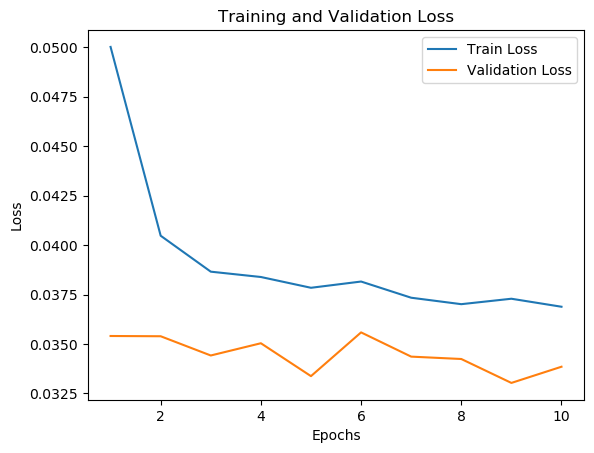

In [12]:
# Plotting Loss
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model_save_path = './saved_models/DenseNet_cifar10_RejDiff_finetuned.pth'
torch.save(DenseNet.state_dict(), model_save_path)
print("Model saved as DenseNet_cifar10_RejDiff_finetuned.pth")

Model saved as DenseNet_cifar10_RejDiff_finetuned.pth


In [14]:
DenseNet.load_state_dict(torch.load(model_save_path))
DenseNet = DenseNet.to(device)

/tmp/ipykernel_318718/1535307420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DenseNet.load_state_dict(torch.load(model_save_path))


In [15]:
final_val_loss, final_val_accuracy, final_precision, final_recall, final_f1 = validate(DenseNet, testloader)
print(f'\nFinal Test Results - Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%, Precision: {final_precision:.2f}, Recall: {final_recall:.2f}, F1 Score: {final_f1:.2f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:32<00:00, 19.22it/s]


Final Test Results - Loss: 0.0339, Accuracy: 81.13%, Precision: 0.82, Recall: 0.81, F1 Score: 0.81
